In [1]:
import bn
import ocr_data_highres as ocr_data
import numpy as np
from IPython.display import clear_output
from importlib import reload
reload(bn)

<module 'bn' from '/home/benland100/Desktop/bn/bn.py'>

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
input_shape = ocr_data.in_2d_shape
conv_kernels = [(3,3)]
conv_outs = [(3,)]
conv_layers = len(conv_kernels)
hidden_shapes = []#[(5,8)]
hidden_layers = len(hidden_shapes)
output_shape = ocr_data.out_shape
print(input_shape,output_shape)

(32, 32) (26,)


In [4]:
layers = []
layers.append(bn.Input(input_shape))
for kernel_shape,out_shape in zip(conv_kernels,conv_outs):
    layers.append(bn.Conv(kernel_shape,out_shape=out_shape))
for hidden_shape in hidden_shapes:
    layers.append(bn.Dense(hidden_shape))
layers.append(bn.Output(output_shape))

s = bn.System()
insts = []
inputs = None
for layer in layers:
    insts.append(layer.construct(s,inputs))
    inputs = insts[-1].outputs
    print(layer, inputs.shape)
s.finalize()

<bn.Input object at 0x7f9276266220> (32, 32)
<bn.Conv object at 0x7f9276266370> (30, 30, 3)
<bn.Output object at 0x7f92762661c0> (26,)


In [5]:
print('IN: %s OUT: %s TOTAL: %i WEIGHTS: %i'%(input_shape,output_shape,len(s.neurons),np.sum([len(n.weights) for n in s.neurons])))

IN: (32, 32) OUT: (26,) TOTAL: 3750 WEIGHTS: 94500


In [6]:
import multiprocessing
import functools

def worker(args):
    true_out,input = args
    guess_out,state = s.guess(input,return_state=True)
    if np.any(guess_out != true_out):
        deltas = s.learn(state,true_out,batch=True,scale=0.2)
    else:
        deltas = None
    return deltas

def s_batch(length):
    total = 0
    failures = 0
    state = None
    for true_out,input in ocr_data.tagged_data(length):
        guess_out,state = s.guess(input,return_state=True,scale=0.2)
        if np.any(guess_out != true_out):
            failures += 1
            s.learn(state,true_out)
        total += 1
    return total,failures

def mp_batch(length,chunk_size,max_pool_size=10):
    pool_size = min(chunk_size,max_pool_size)
    total,failures = 0,0
    while total < length:
        size = min(chunk_size,length-total)
        try:
            p = multiprocessing.Pool(pool_size)
            chunk_deltas = [deltas for deltas in p.map(worker,ocr_data.tagged_data(size)) if deltas is not None]
        except KeyboardInterrupt:
            raise
        finally:
            p.close()
        total += size
        failures += len(chunk_deltas)
        if len(chunk_deltas) > 0:
            s.apply_deltas(chunk_deltas[0],batch=False)
    return total,failures

def batch(length=1000,initial_size=None,min_chunk_size=2):    
    if initial_size is None:
        initial_size = int(length/10)
    total,failures = mp_batch(initial_size,initial_size)
    chunk_size = round(1.2*total/failures) if failures > 0 else total
    if chunk_size < min_chunk_size:
        print('Running Serial Batch')
        sub_t,sub_f = s_batch(length-total)
        return sub_t+total,failures+sub_f
    else:
        print('Using batch chunk_size',chunk_size)
        return mp_batch(length,chunk_size)

In [7]:
%prun batch(100)

Running Serial Batch
 

In [ ]:
try:
    batch_size = 500
    while True:
        cases,failures = batch(batch_size)
        print('batch accuracy',cases-failures,'/',cases)
        if (cases-failures)/cases > 0.999:
            break
except KeyboardInterrupt:
    print('Stopped by user')

-9.016818192899338


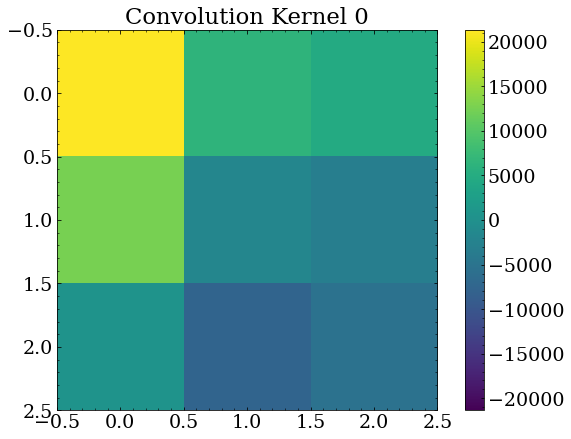

-161.19977906655927


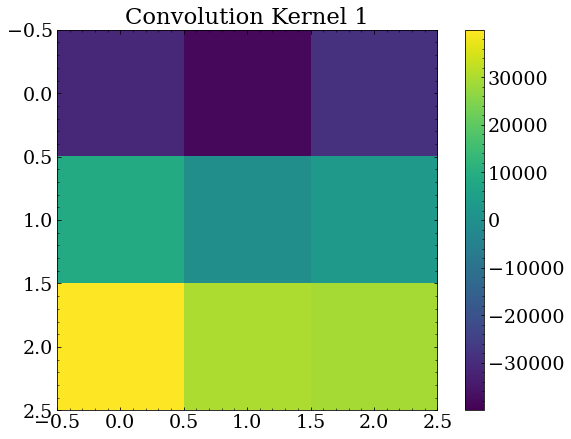

-0.2327762143644203


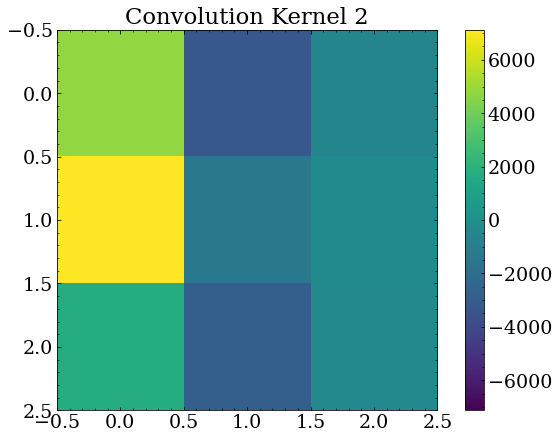

In [15]:
from matplotlib.colors import Normalize

for i,index in enumerate(np.ndindex(conv_outs[0])):
    img_conv = insts[1].neurons[i].weights.reshape(conv_kernels[0])
    print(insts[1].neurons[i].threshold)
    norm = np.max(np.abs(img_conv))
    norm = Normalize(-norm,norm)
    plt.figure()
    plt.title('Convolution Kernel %s'%index)
    plt.imshow(img_conv,norm=norm)
    plt.colorbar()
    plt.show()
    plt.close()

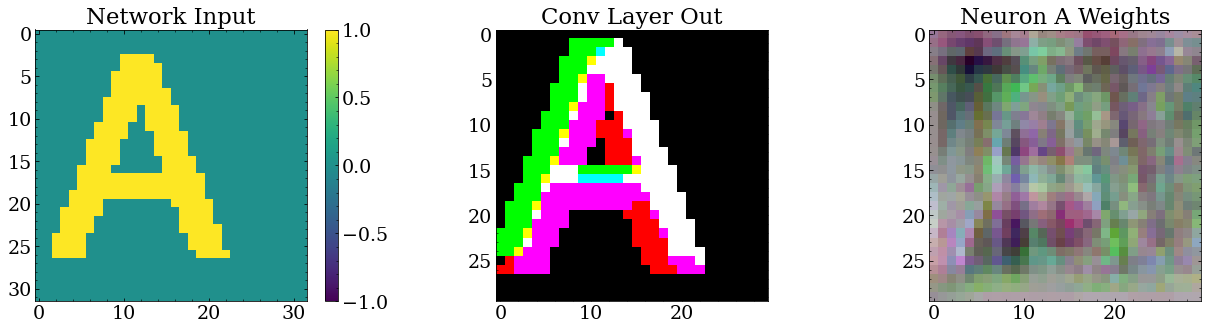

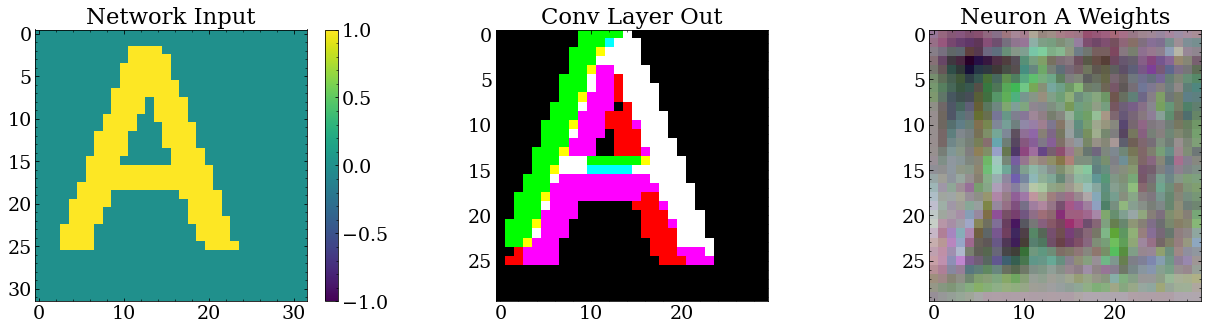

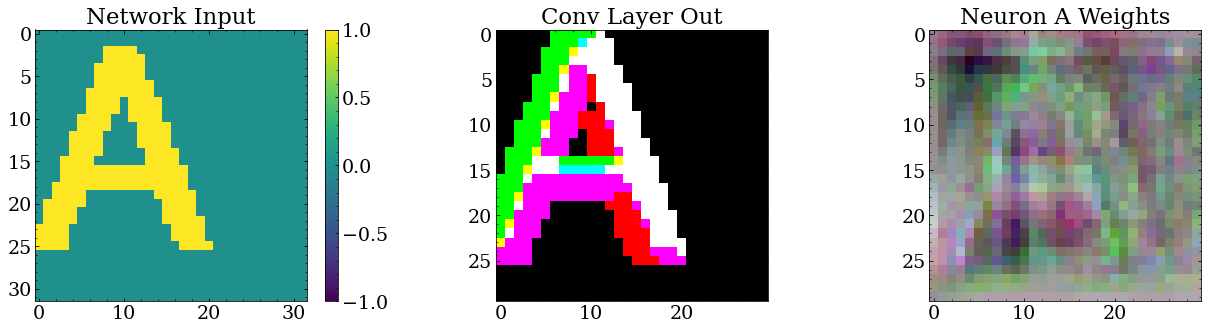

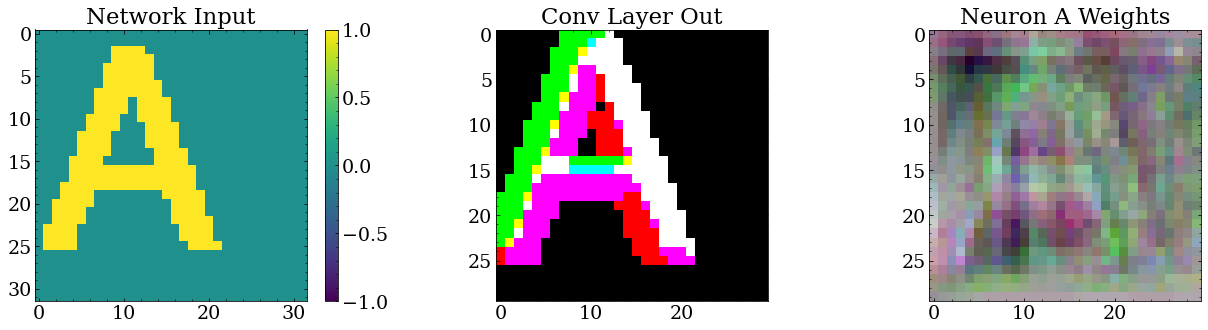

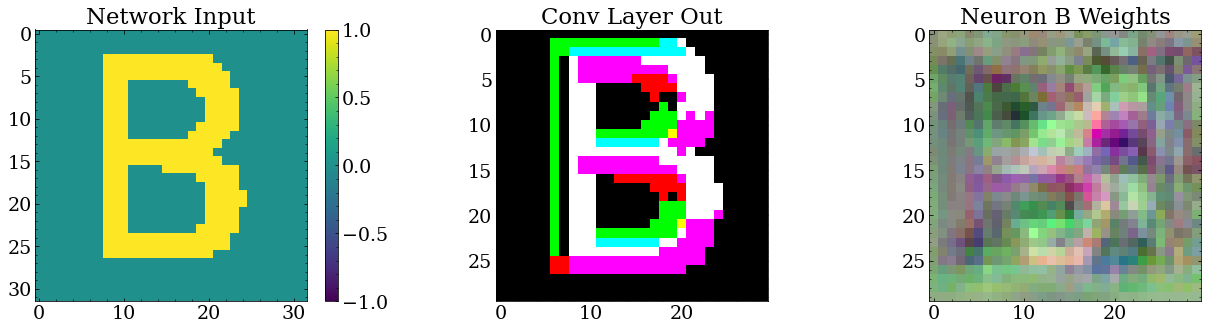

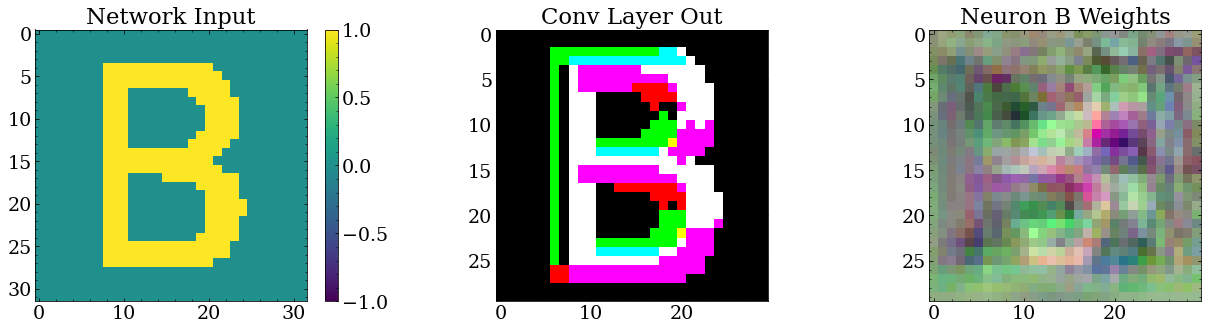

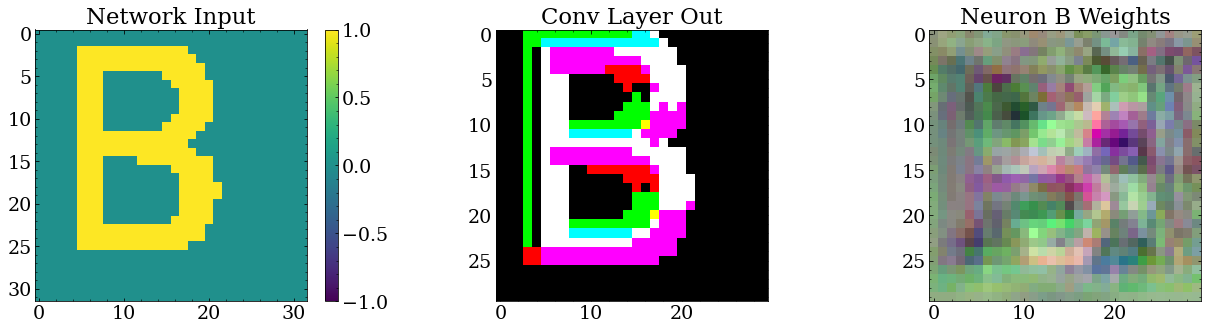

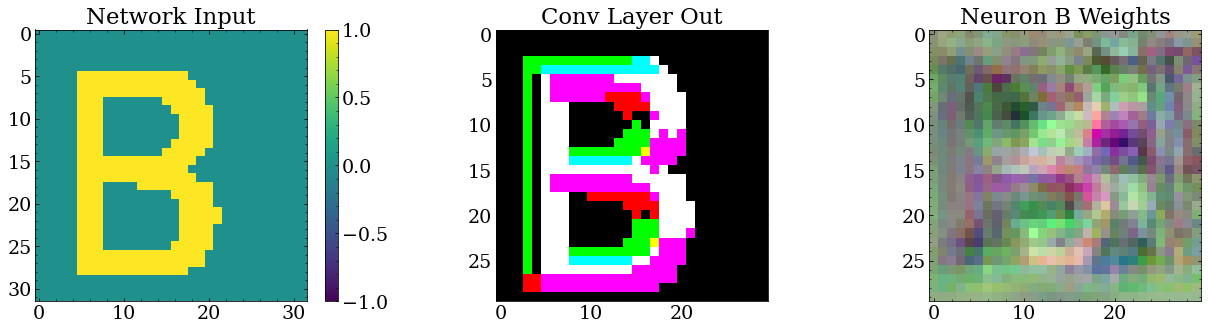

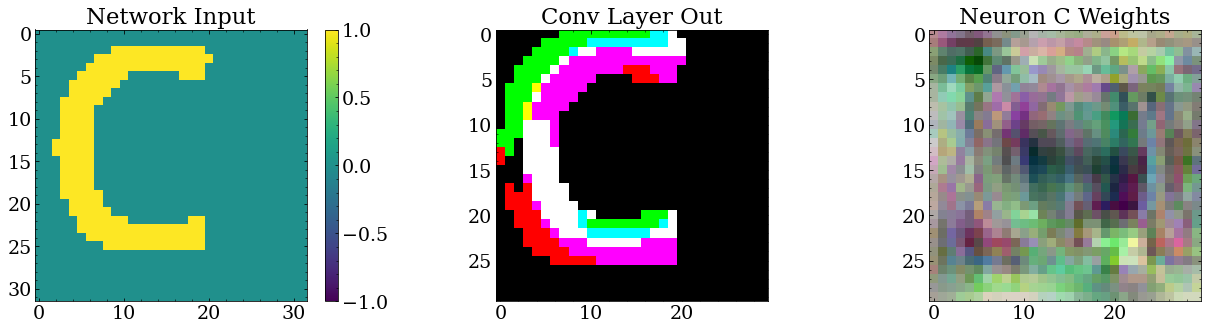

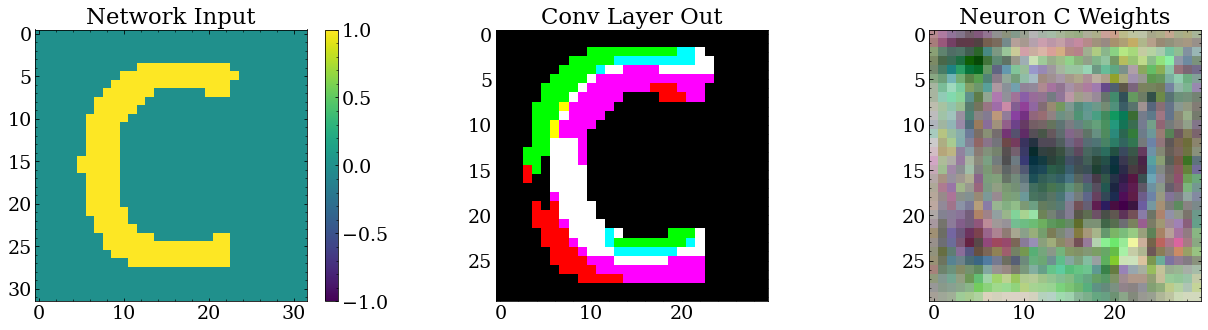

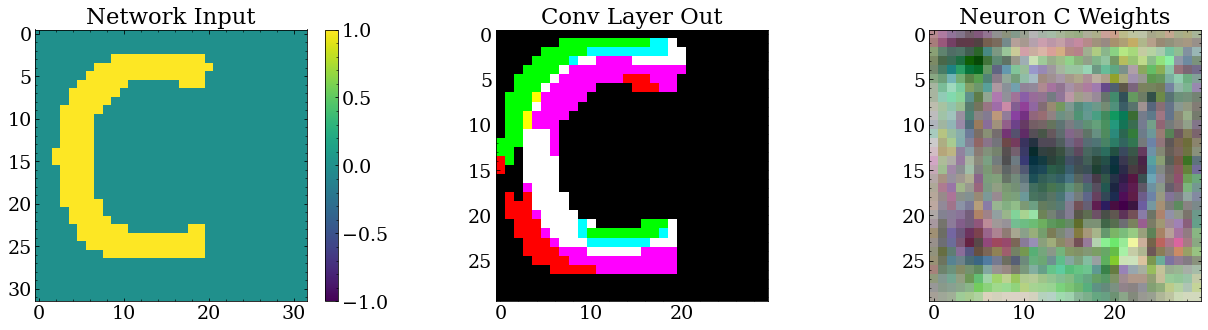

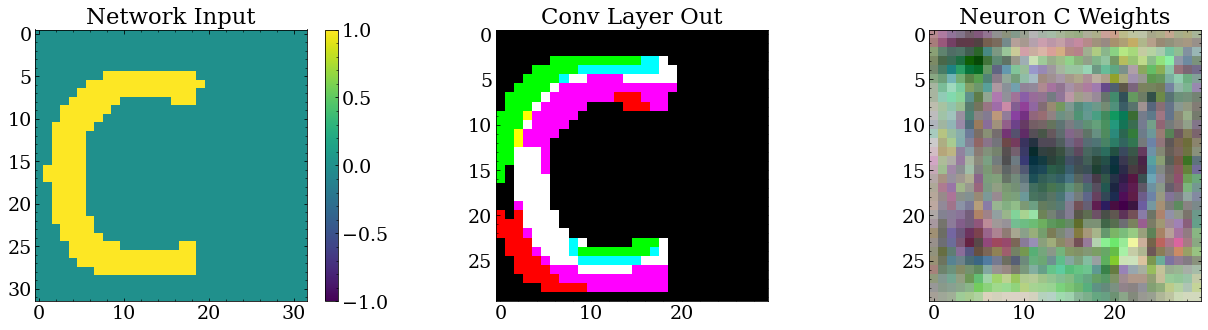

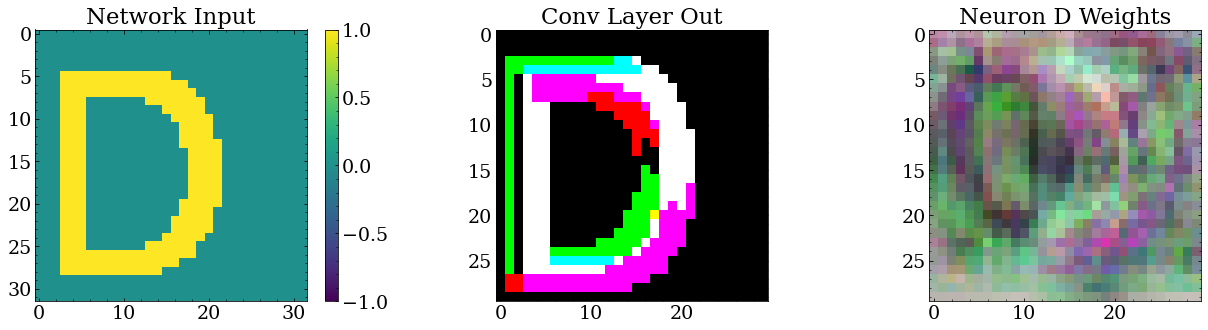

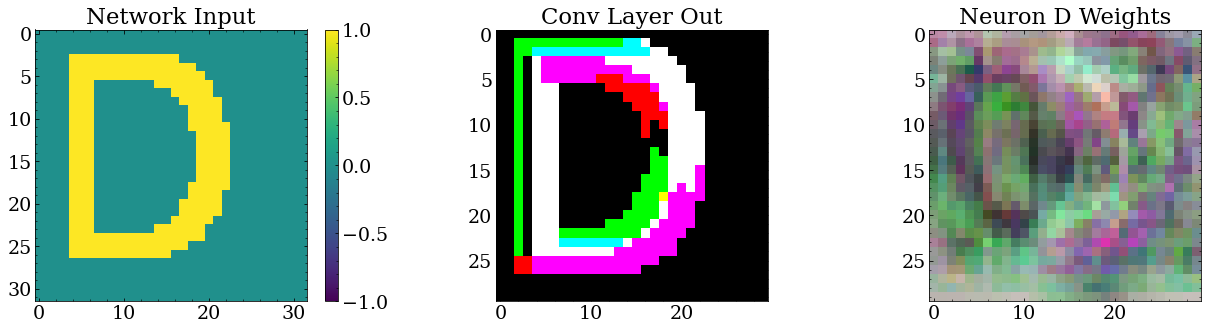

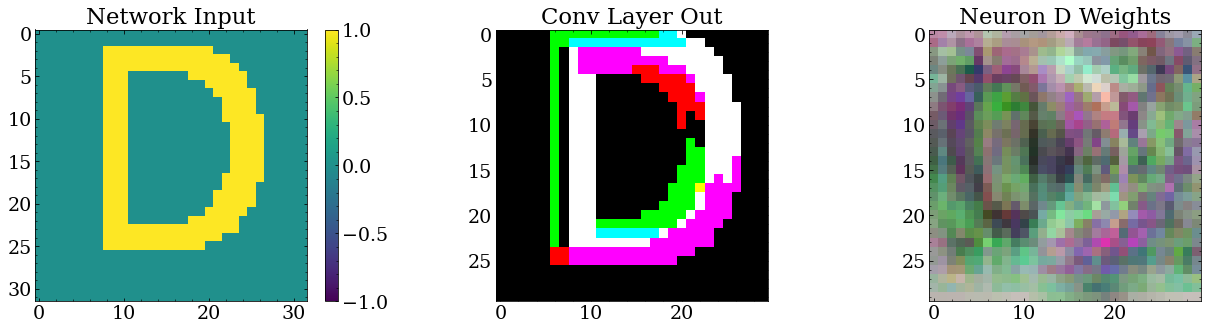

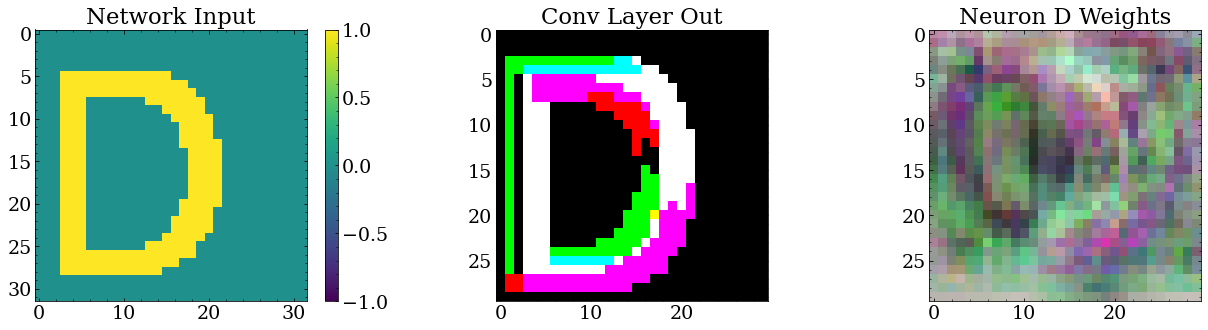

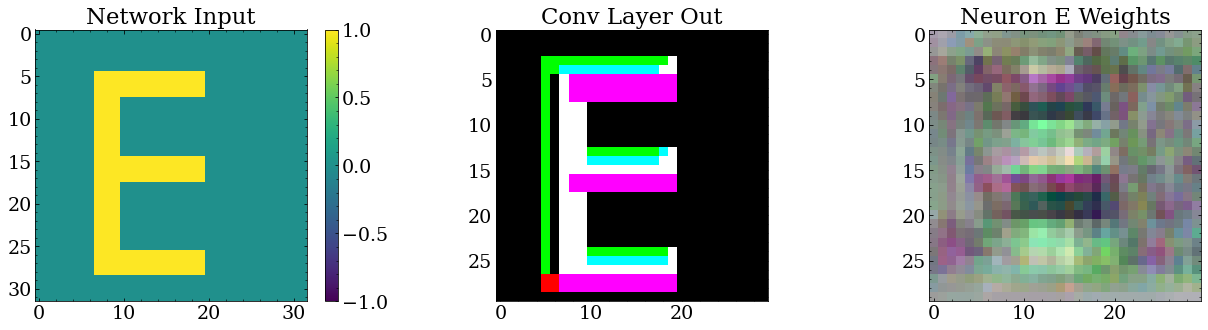

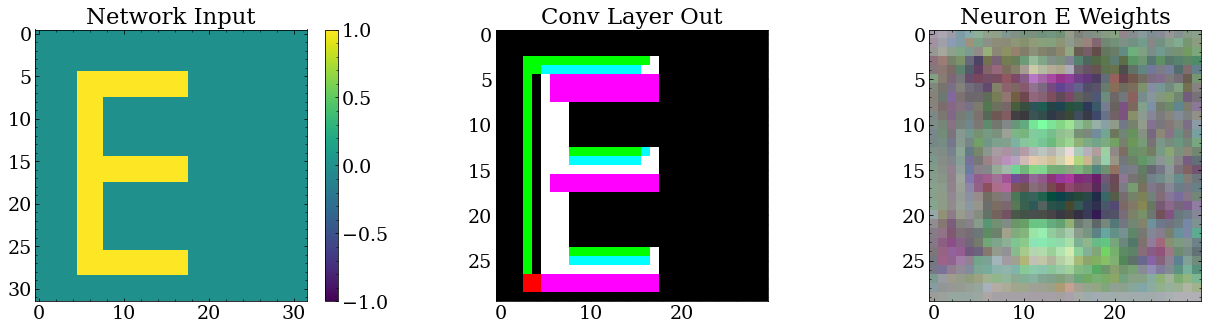

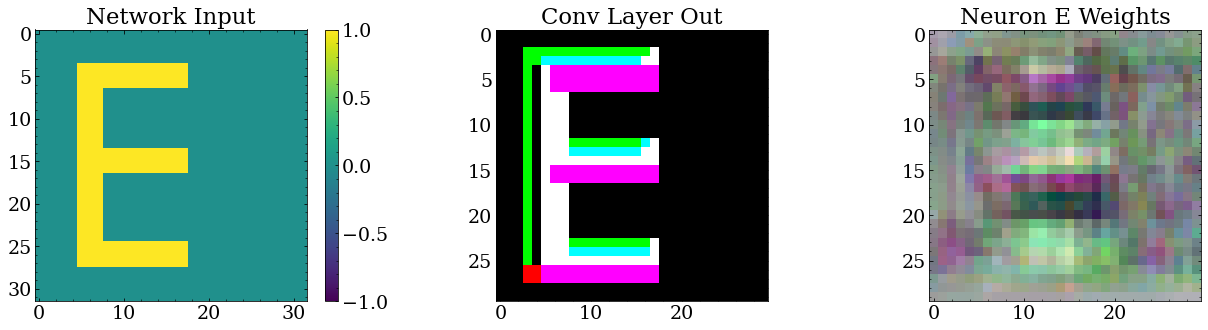

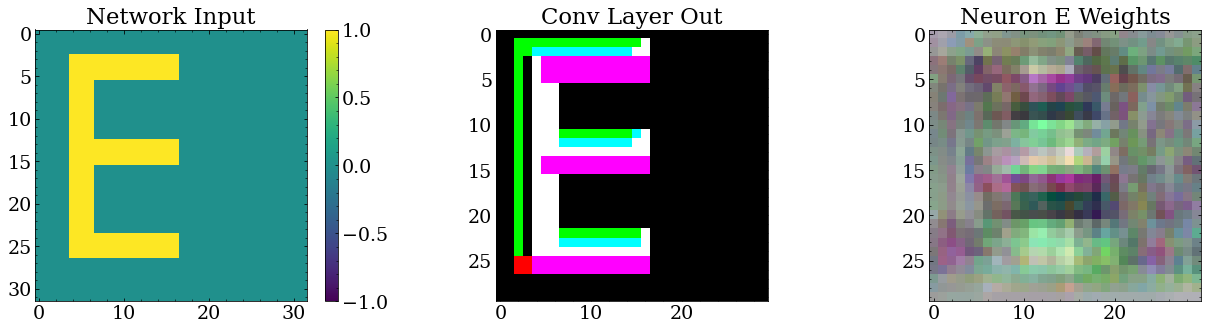

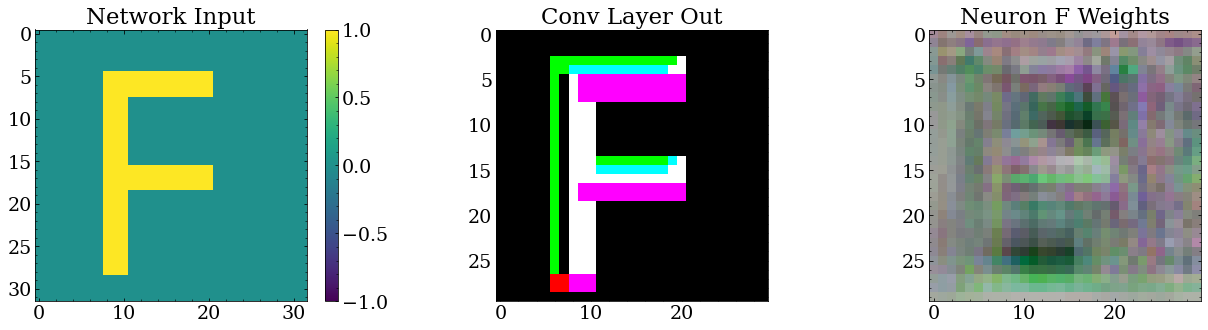

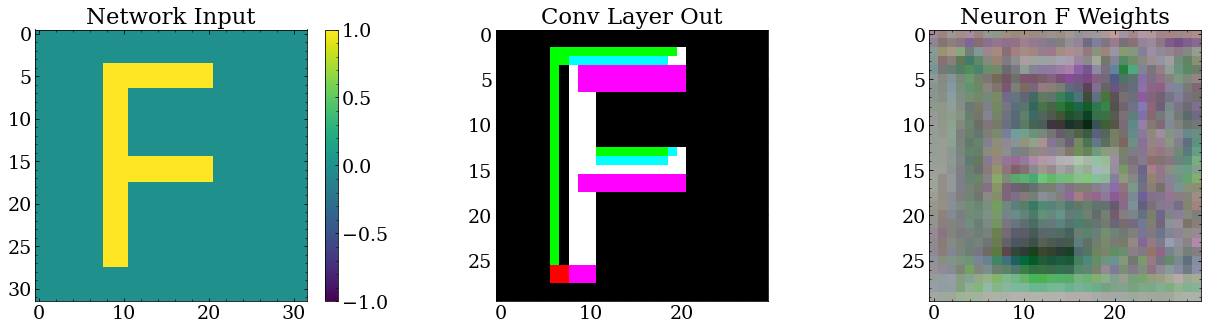

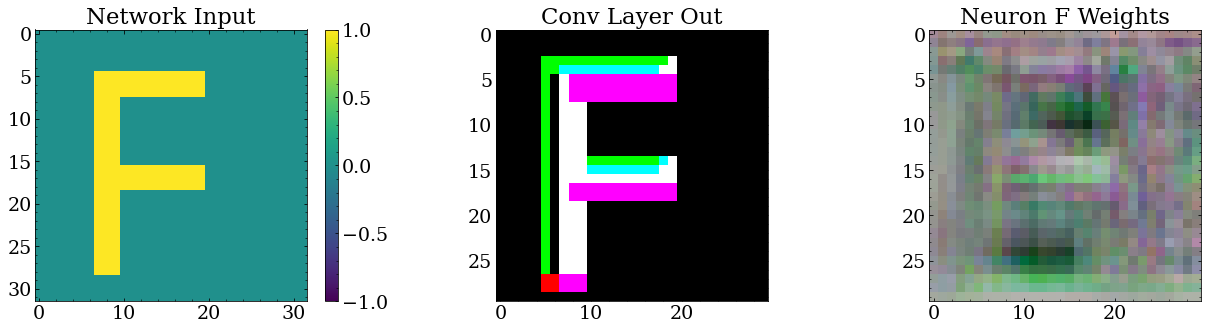

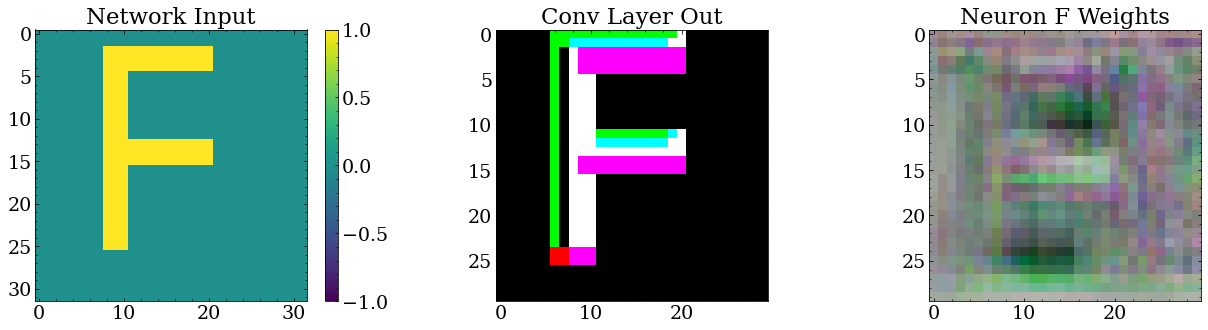

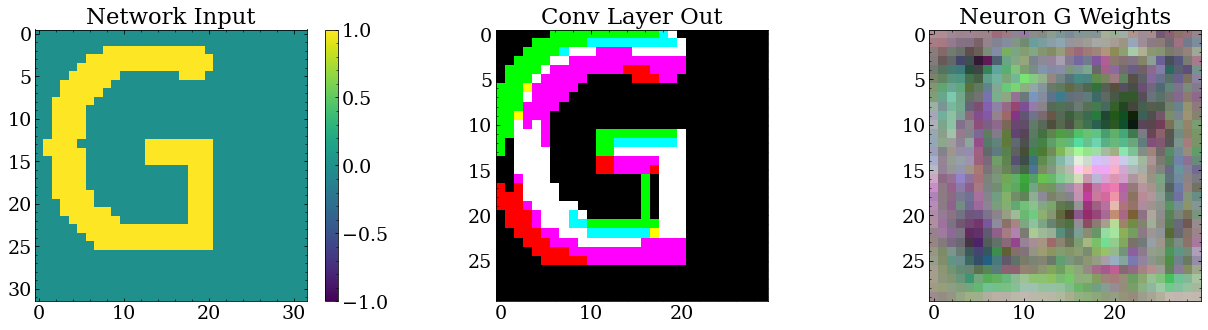

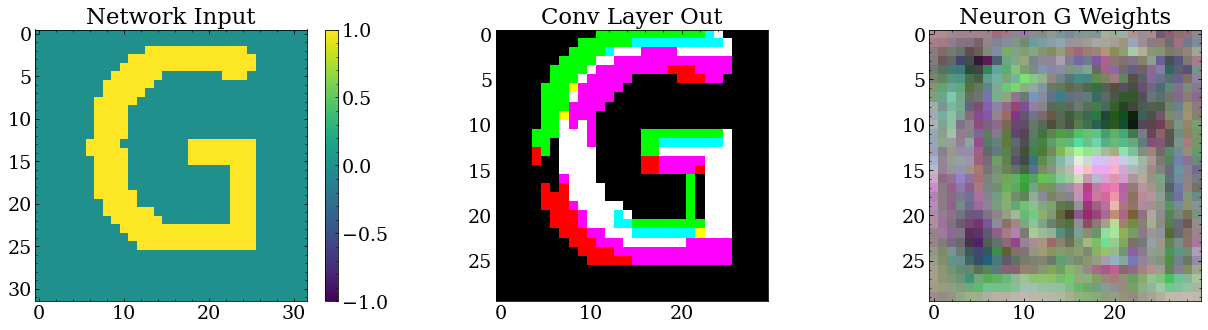

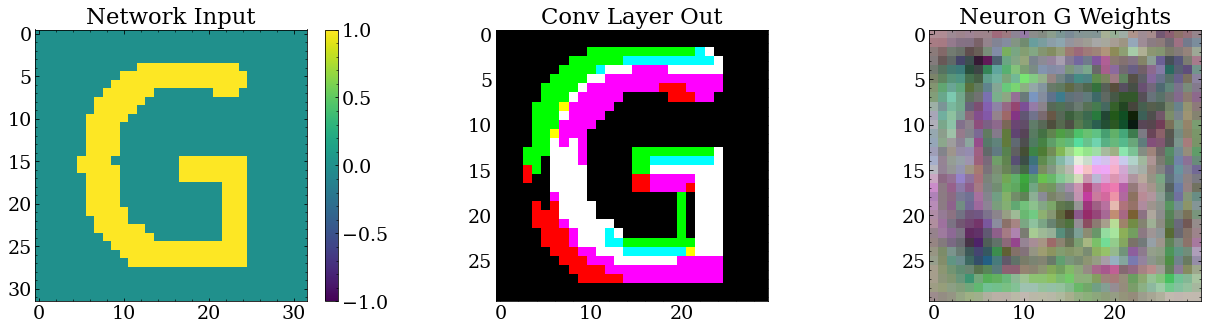

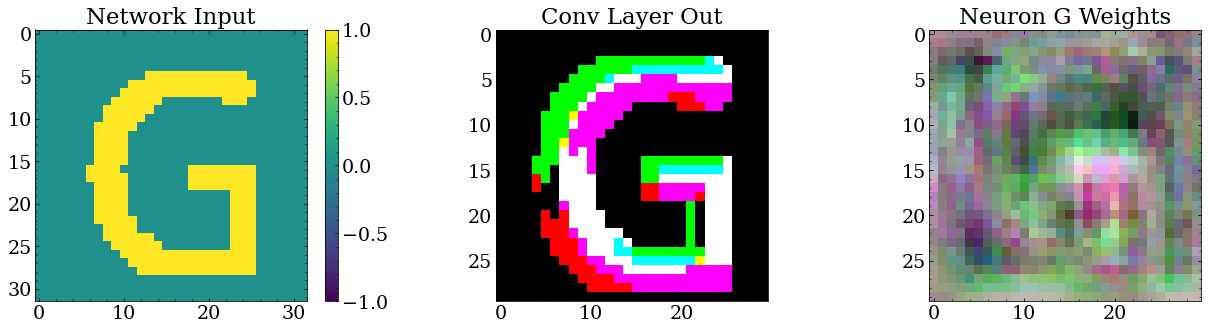

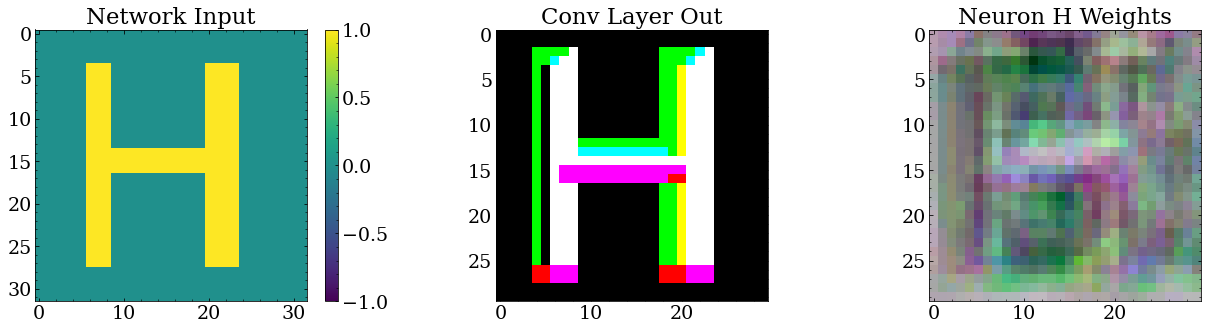

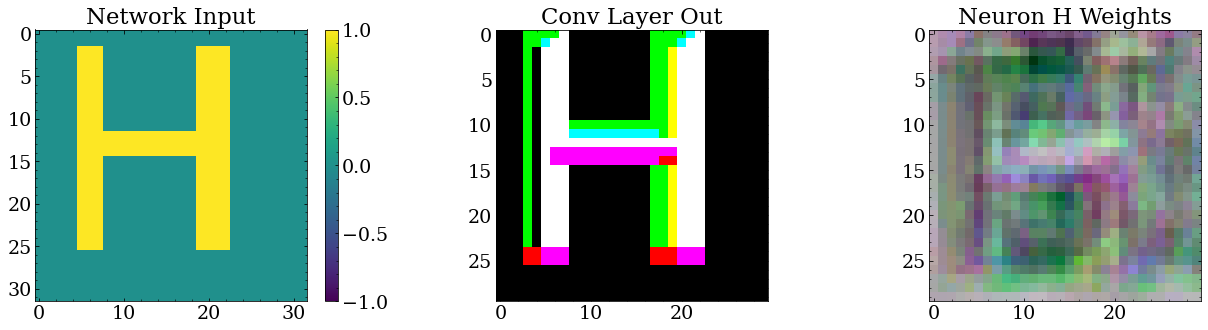

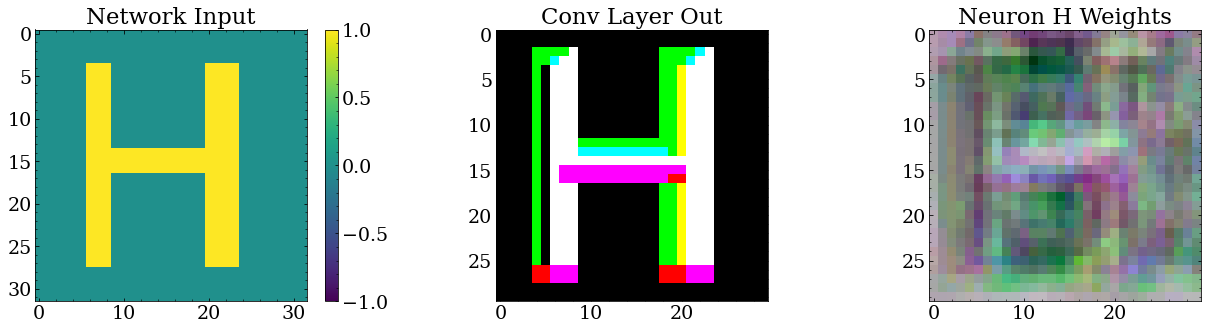

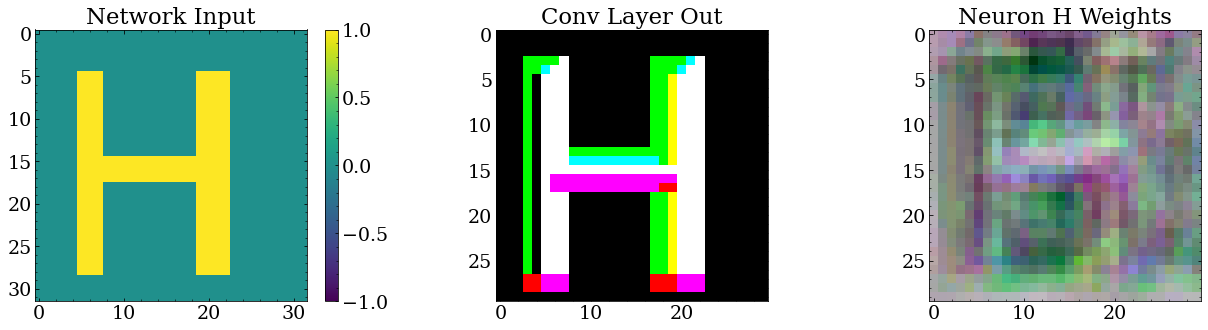

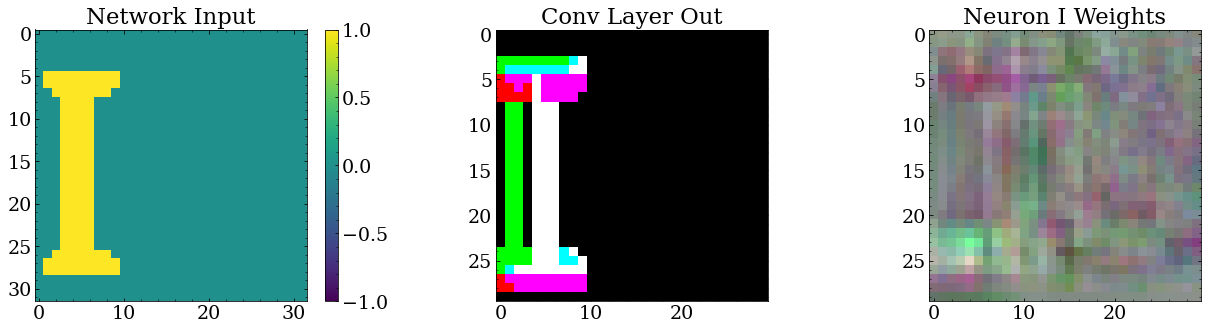

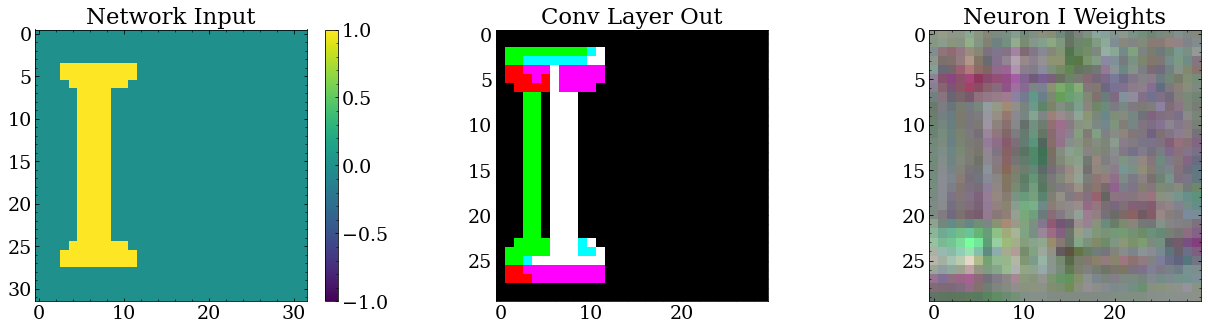

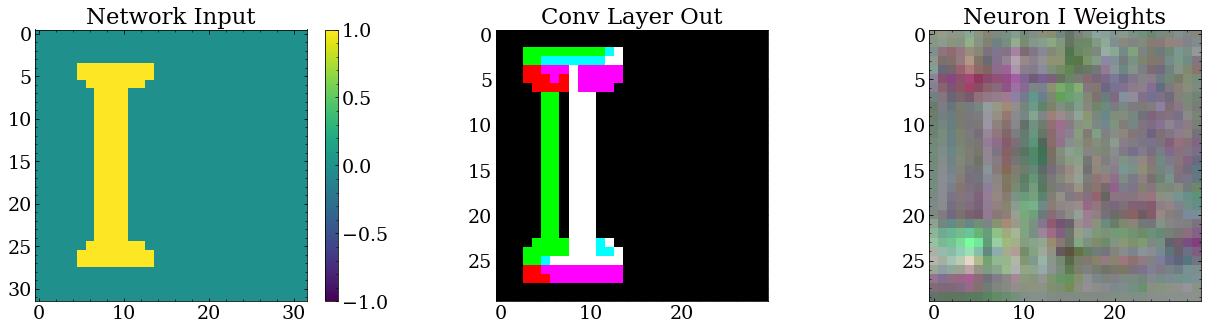

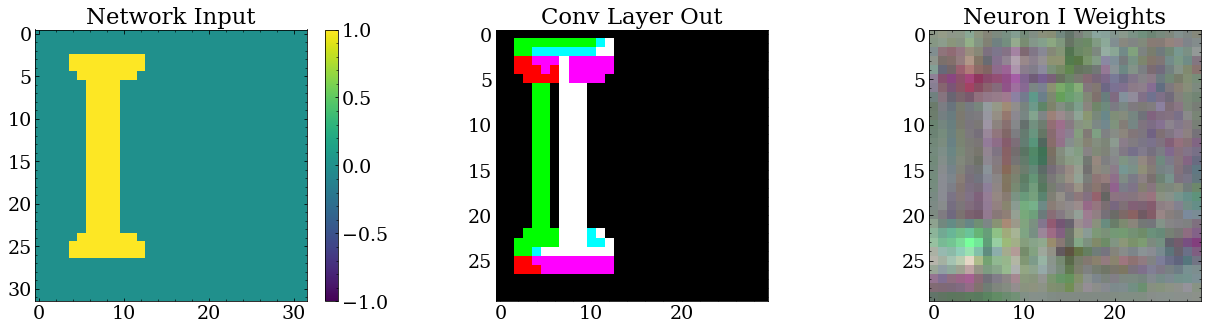

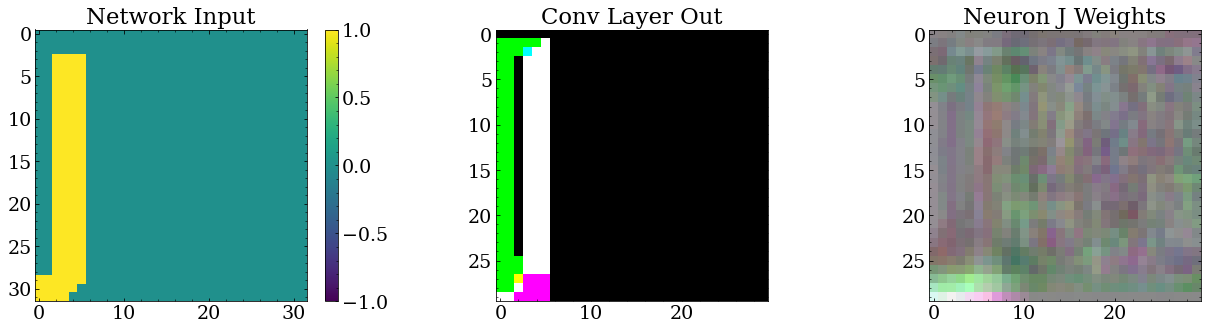

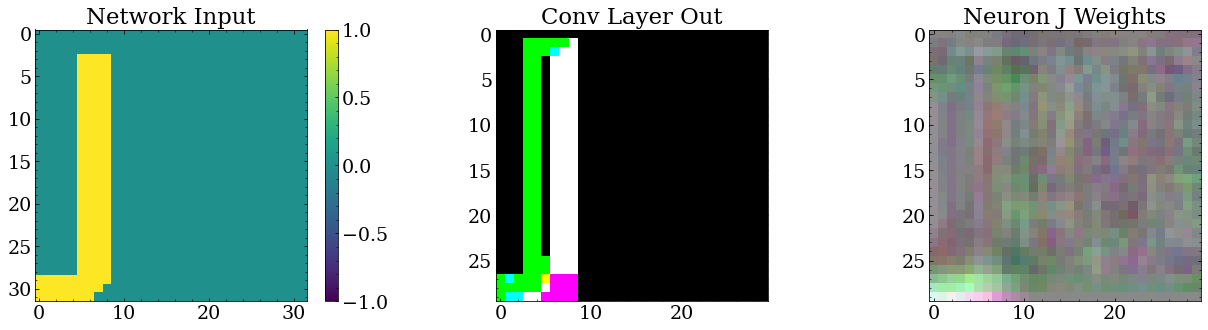

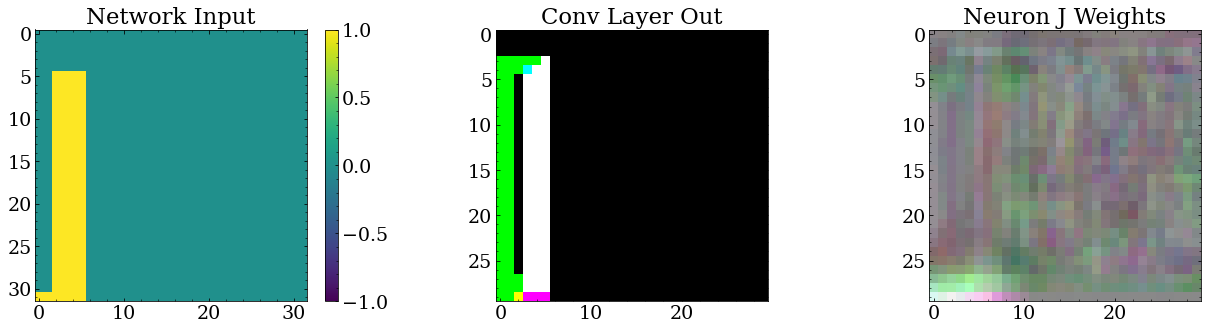

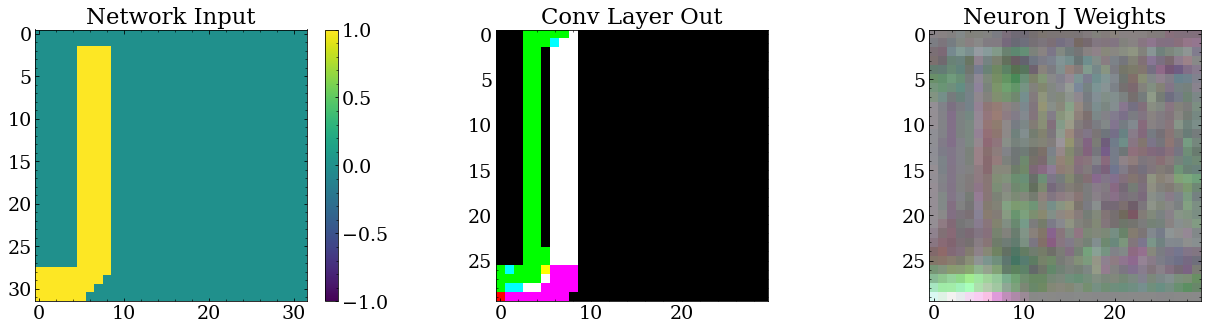

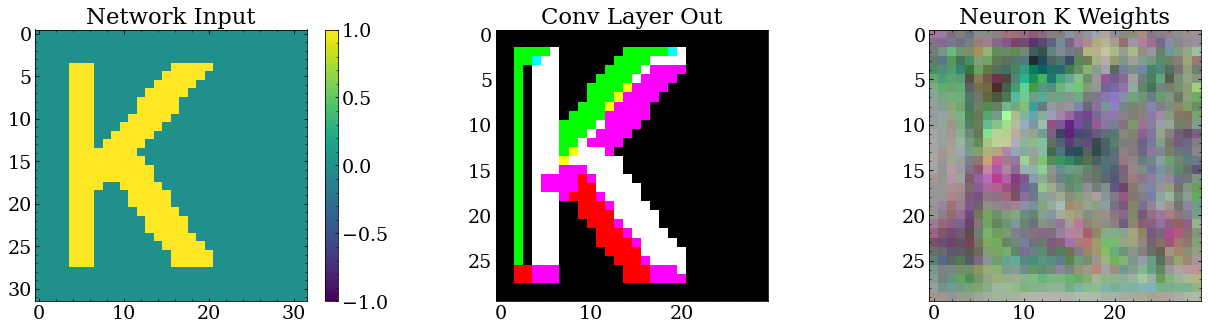

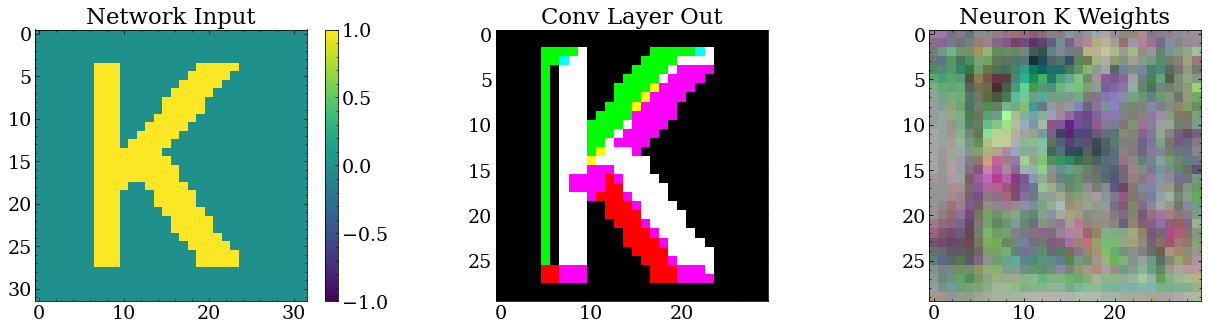

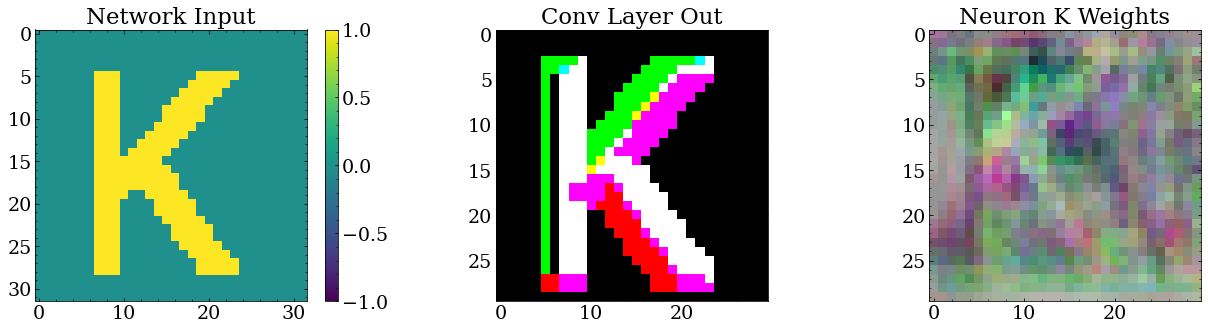

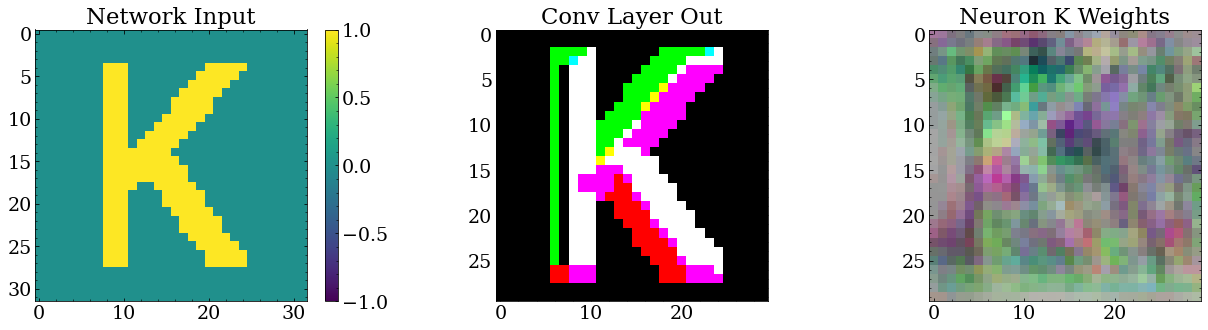

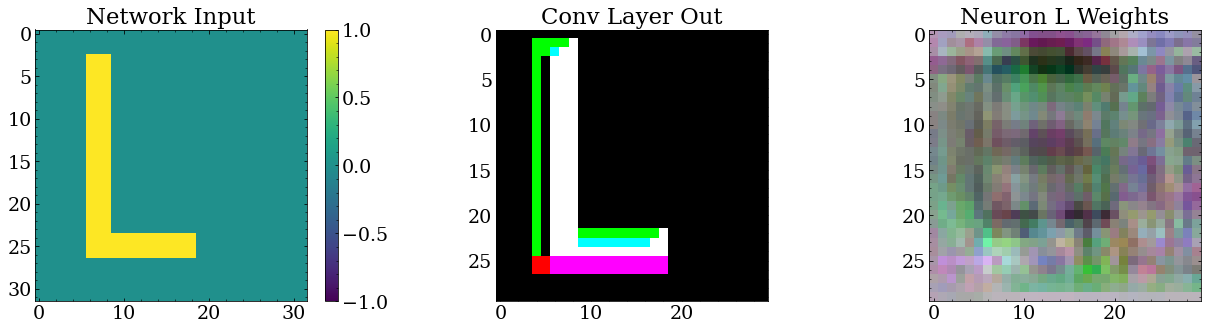

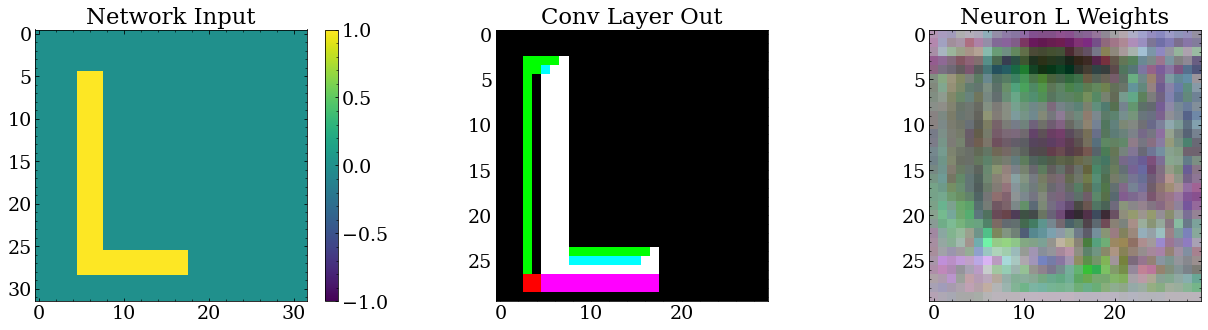

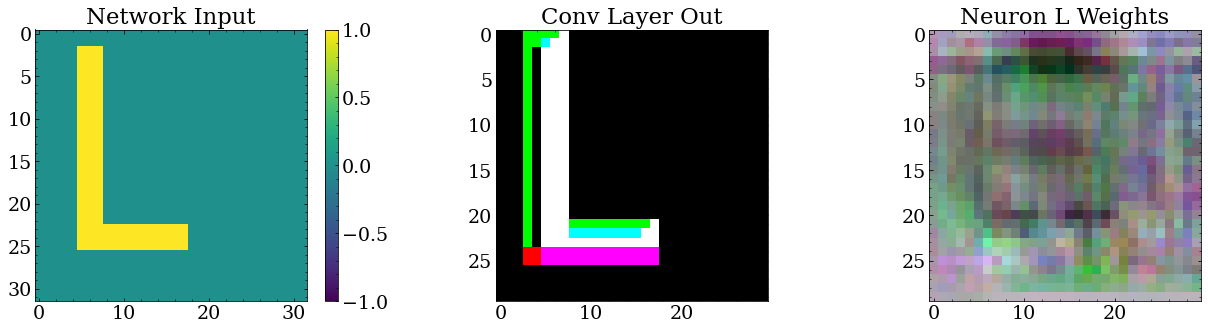

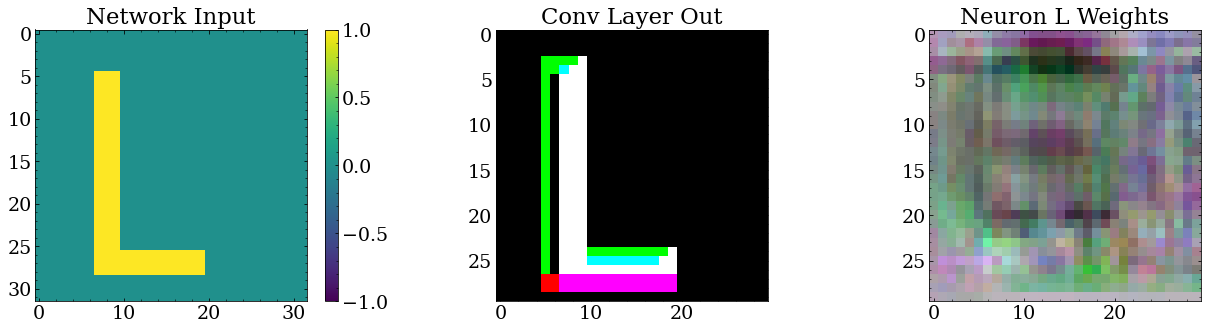

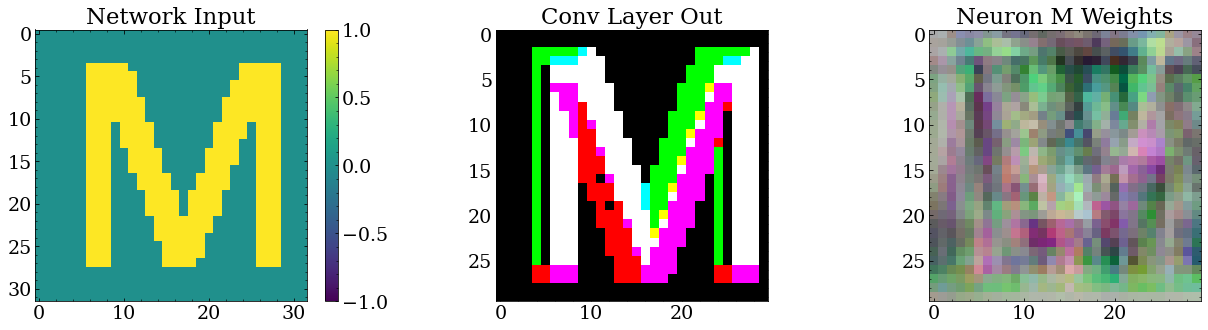

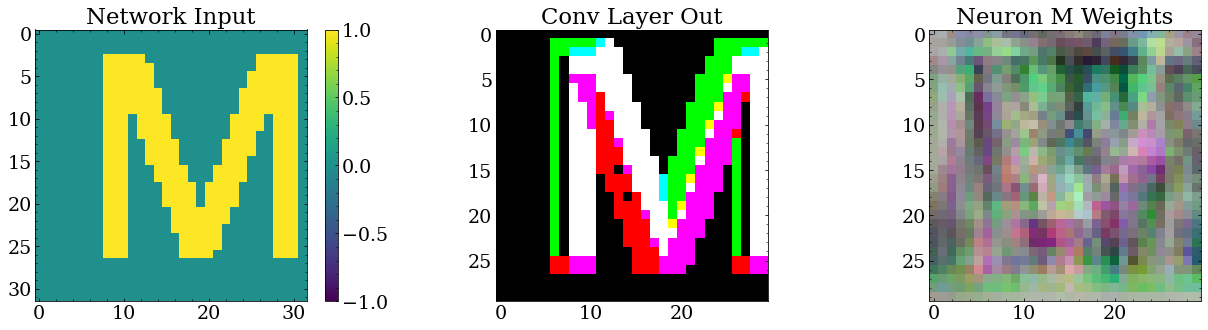

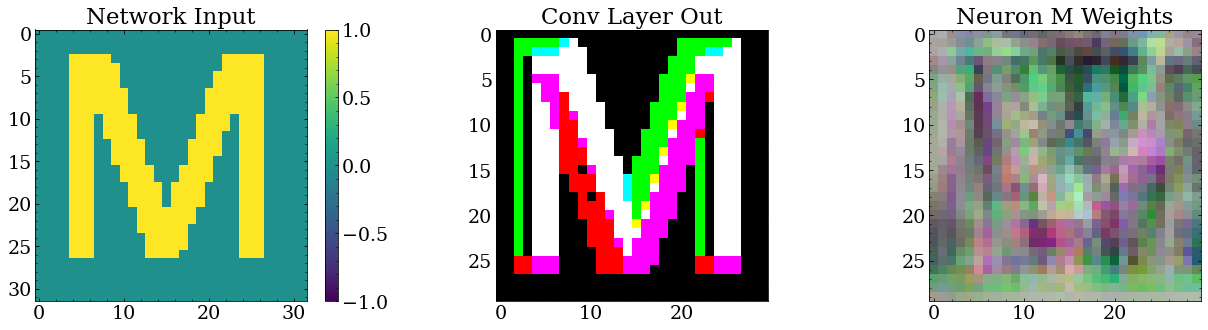

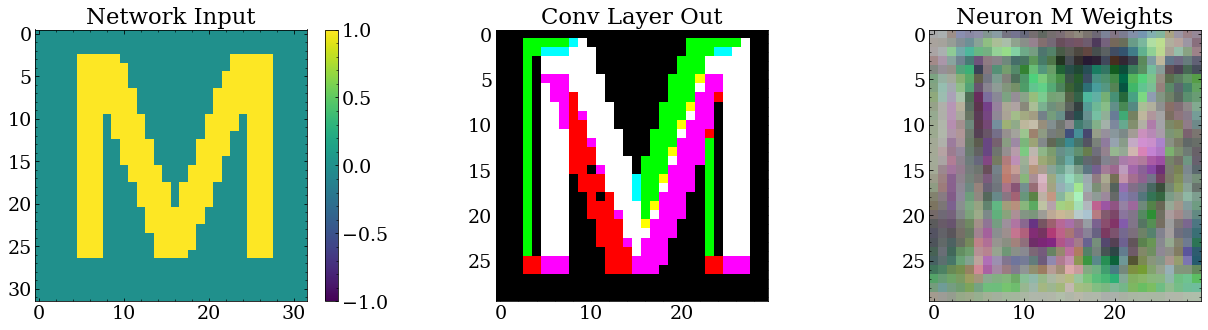

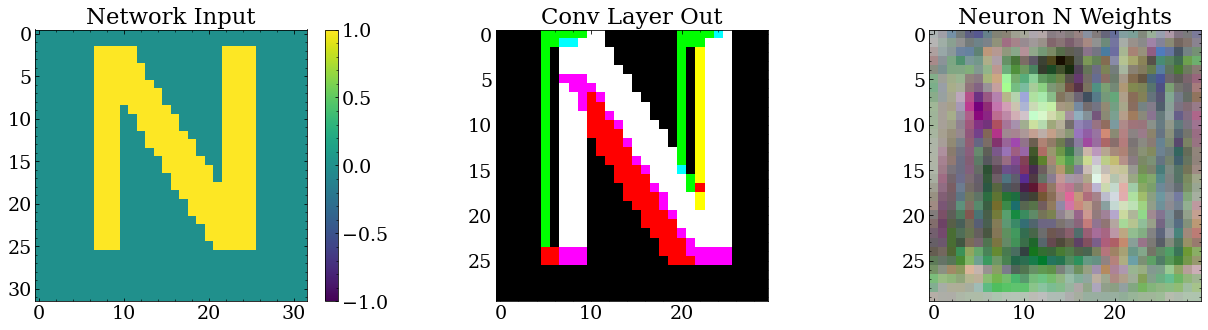

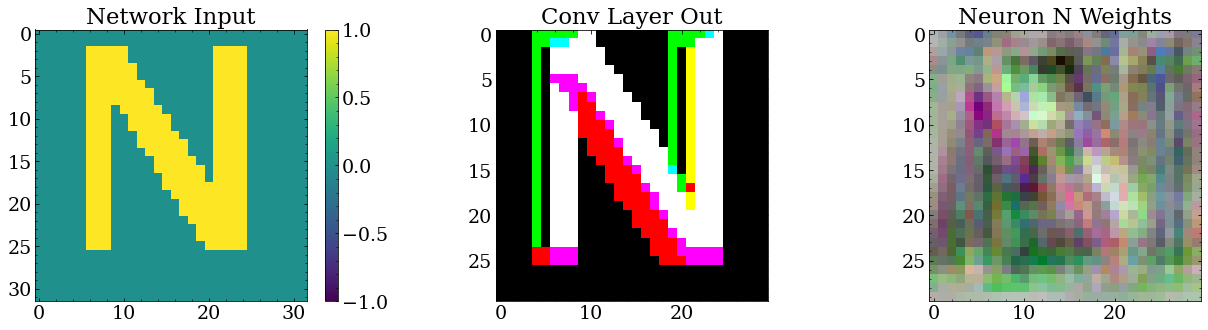

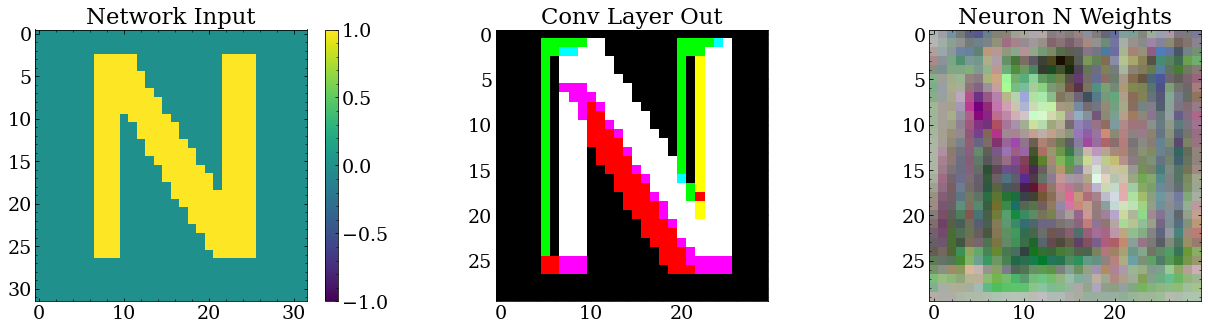

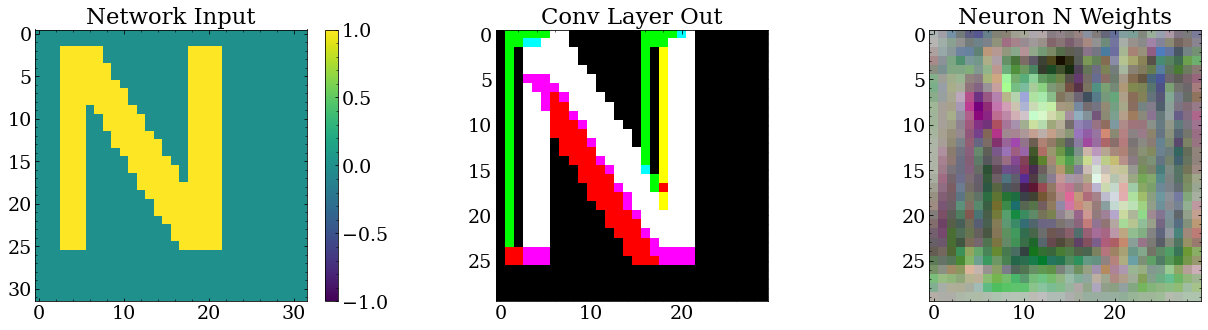

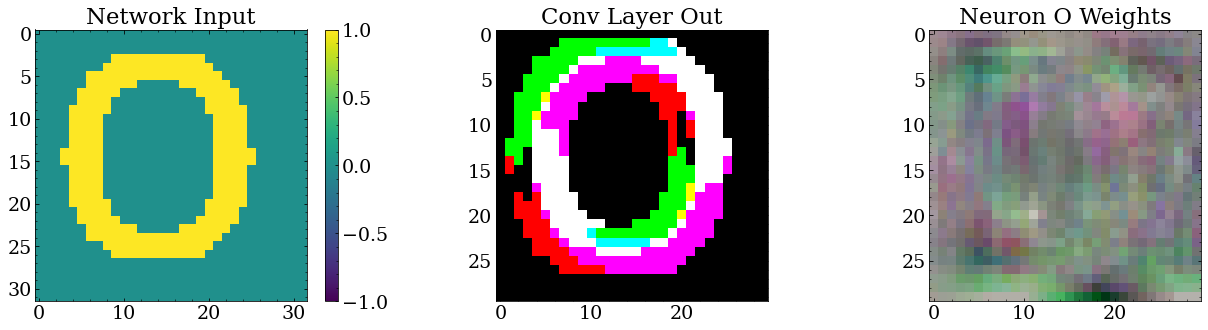

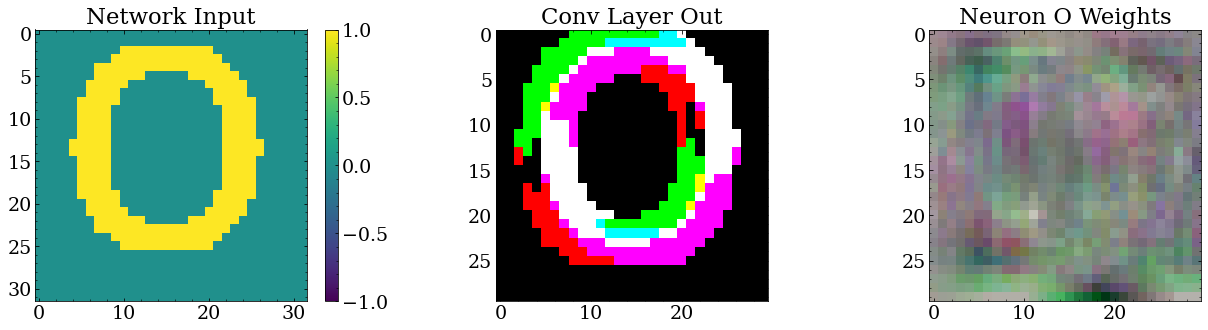

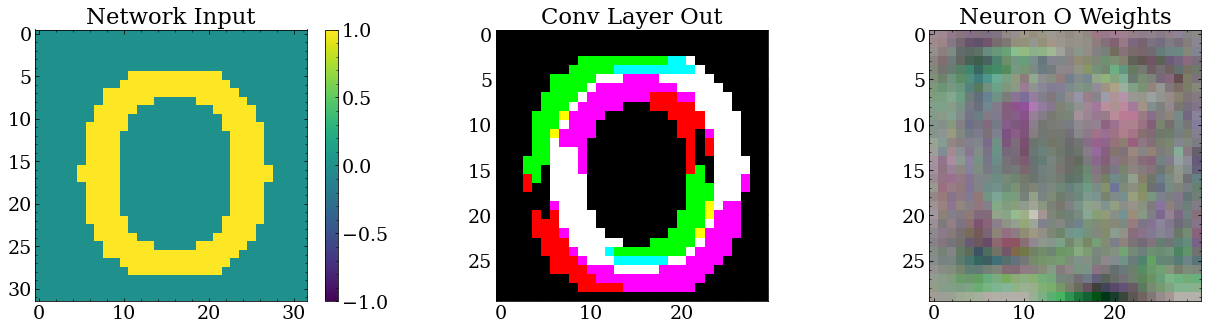

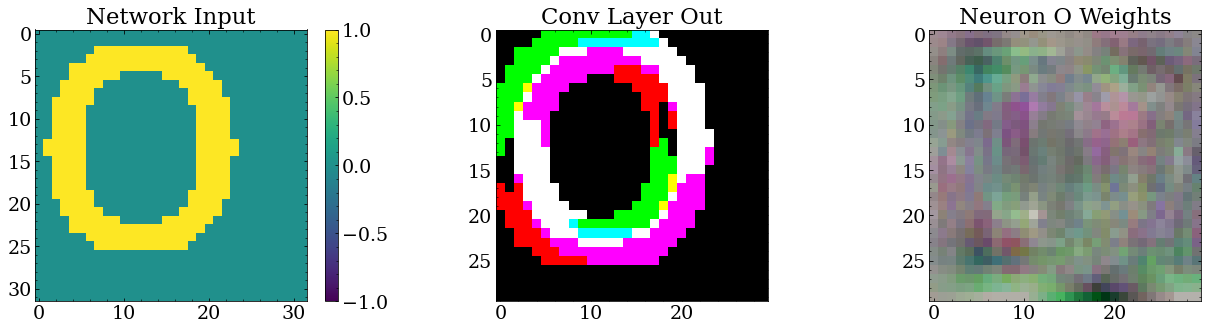

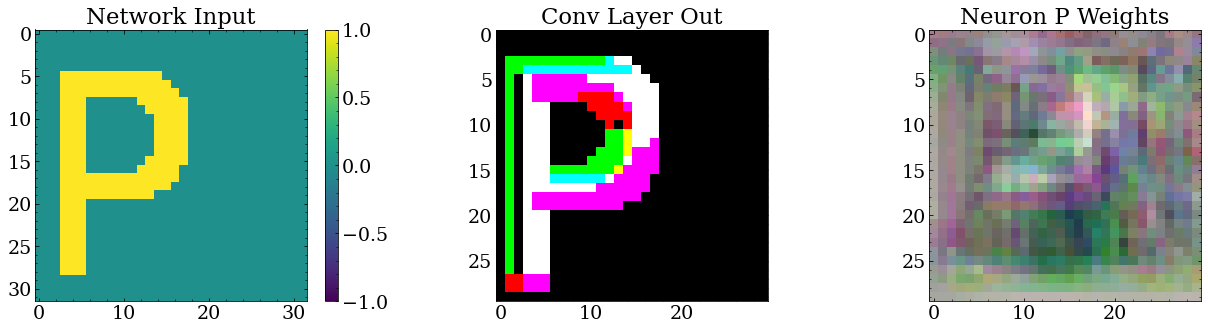

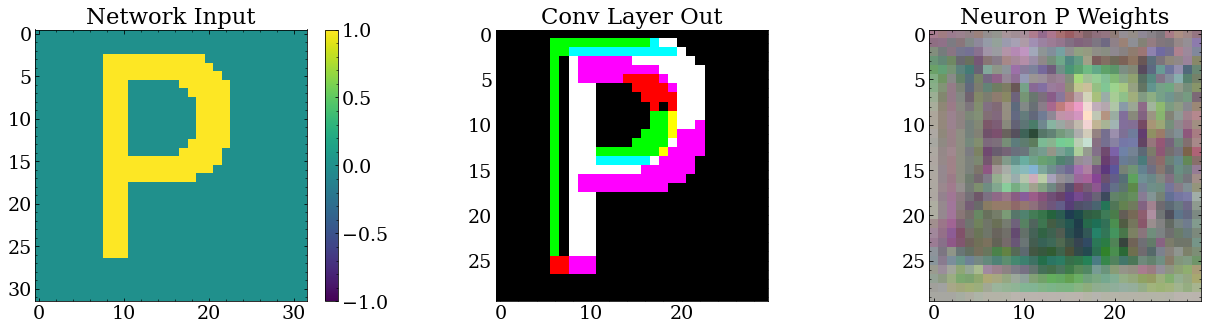

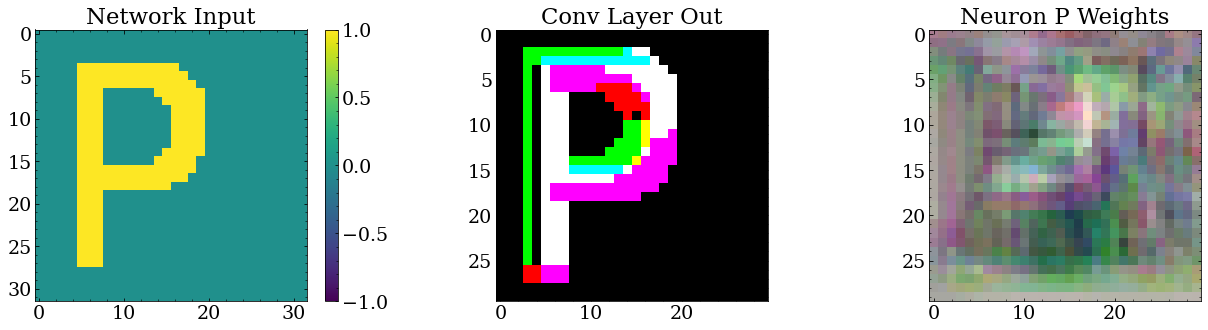

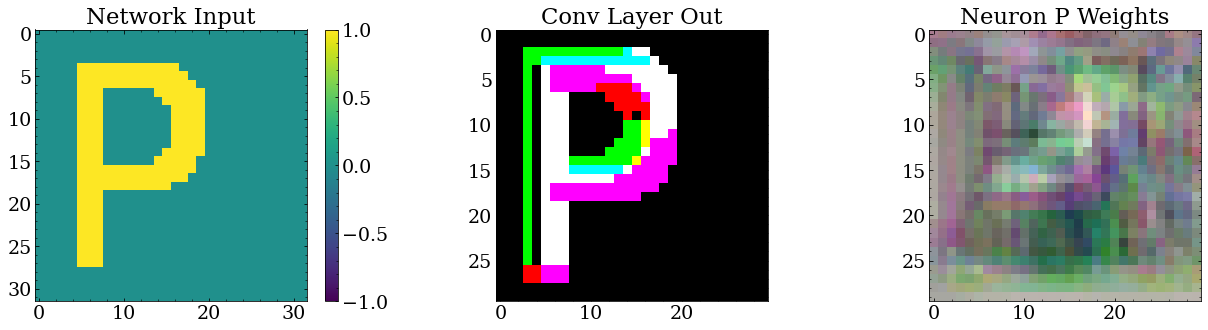

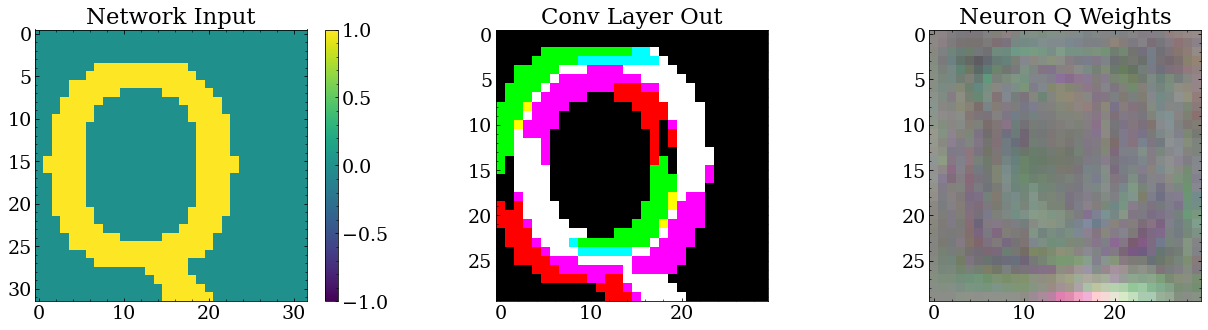

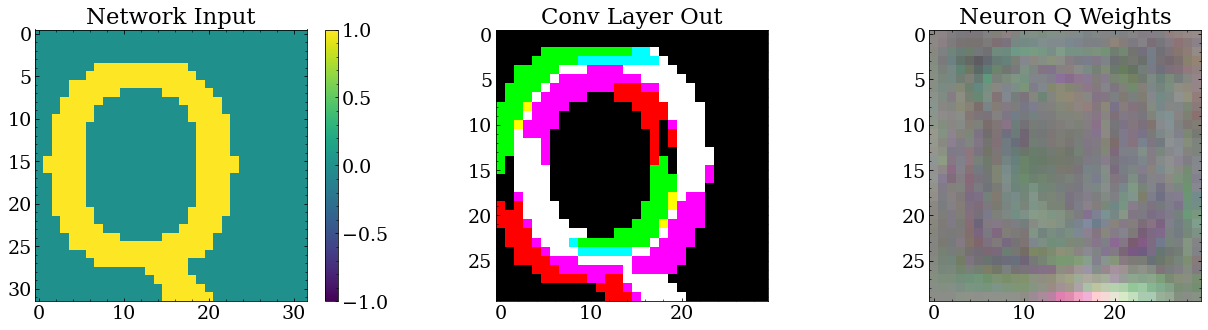

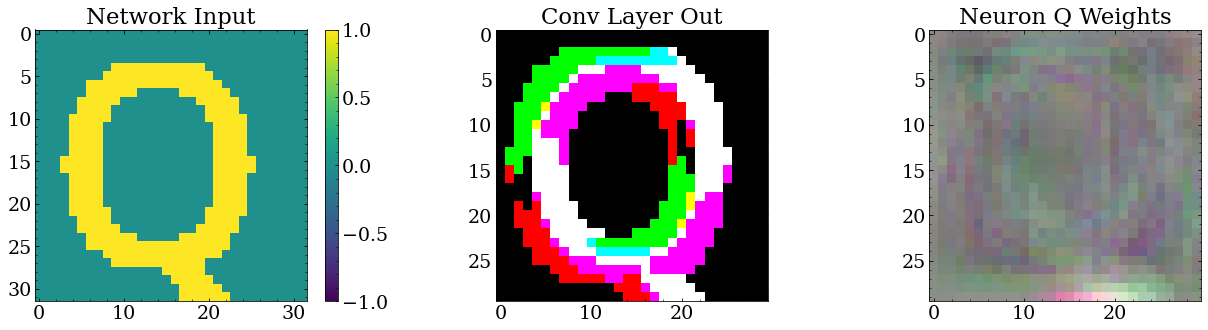

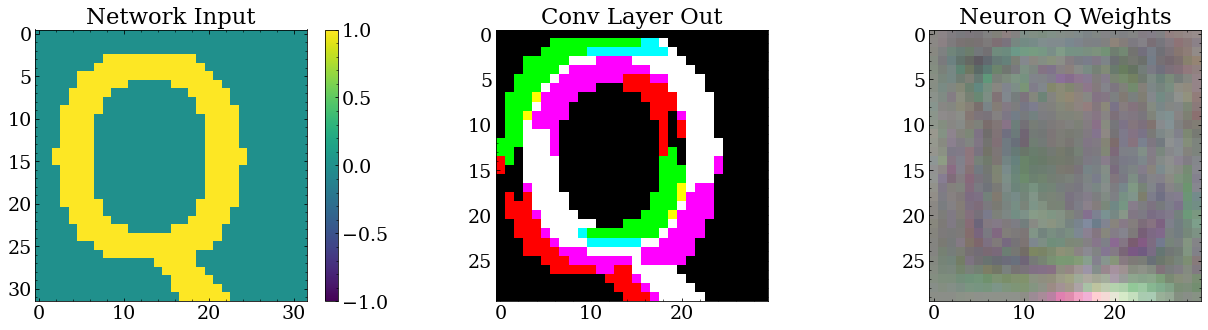

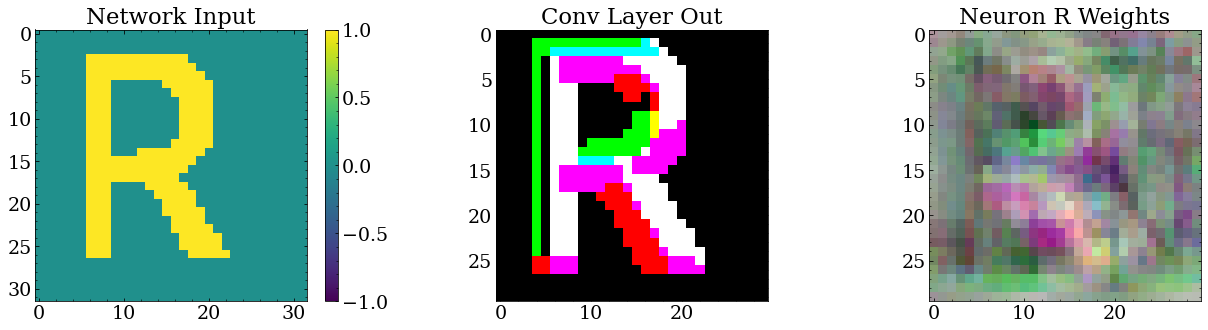

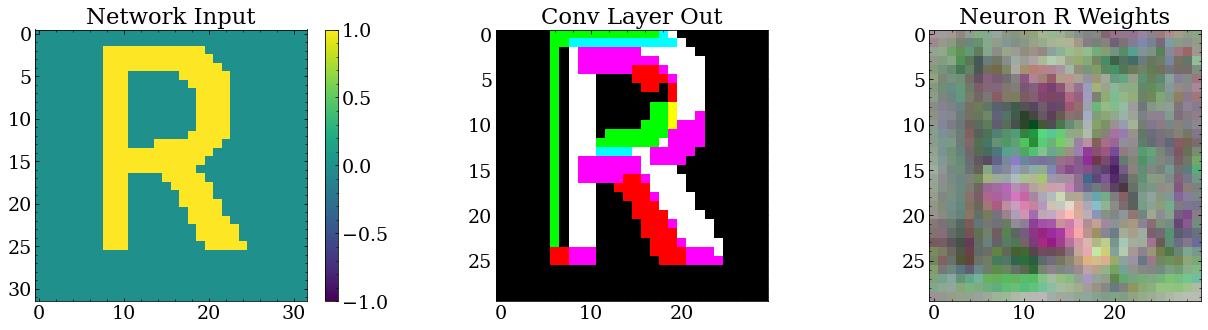

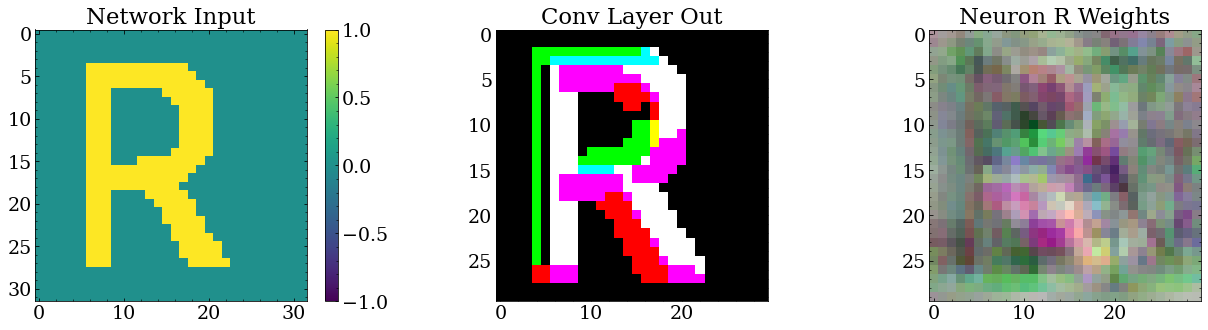

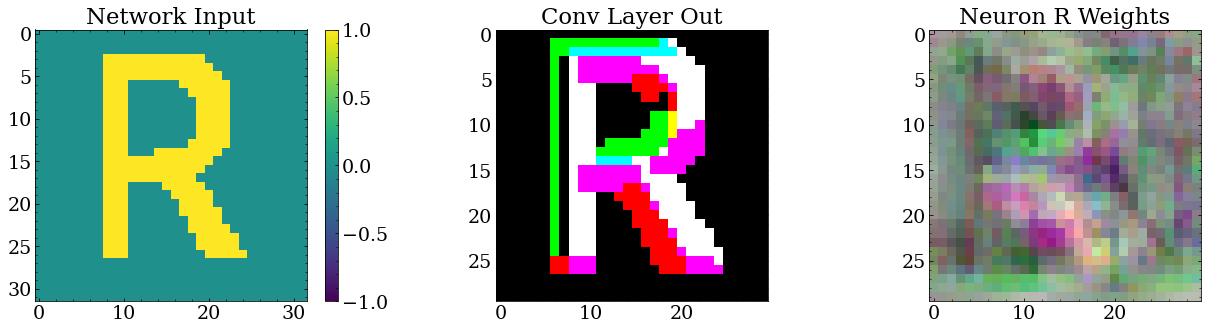

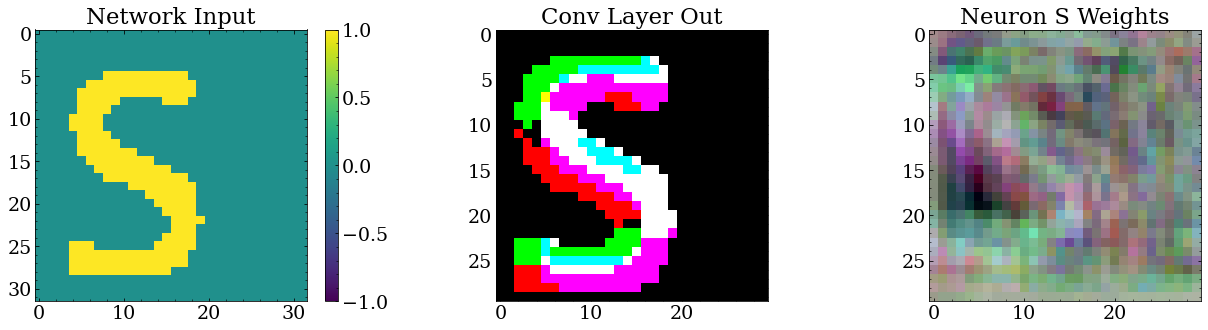

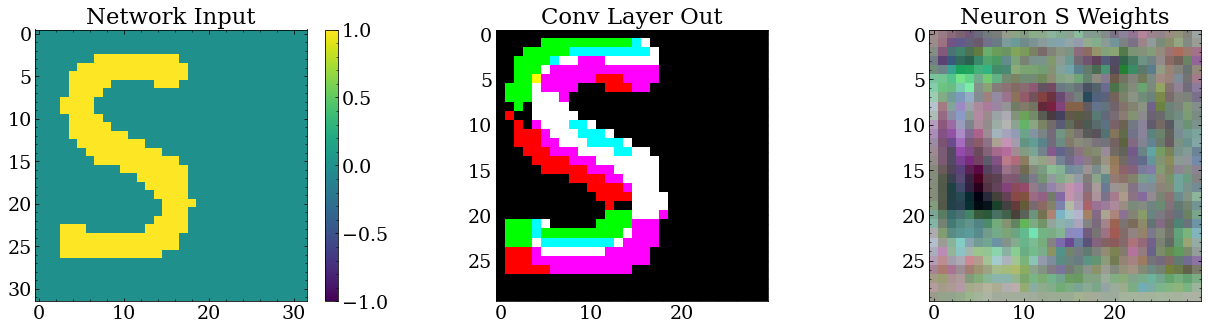

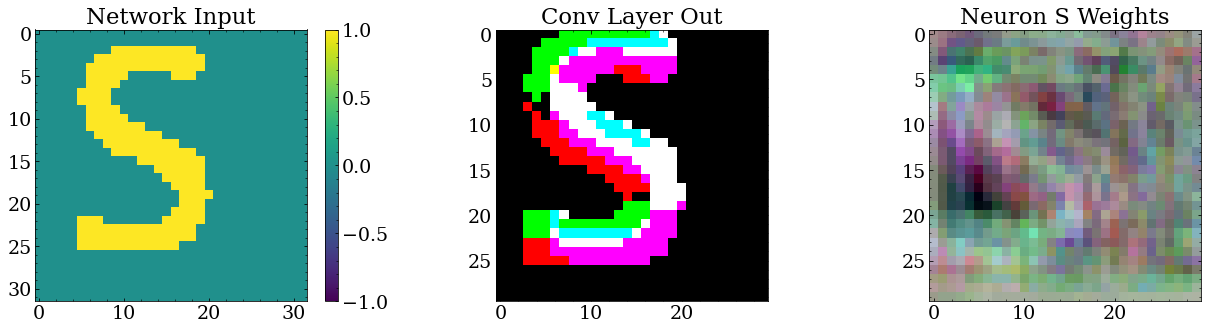

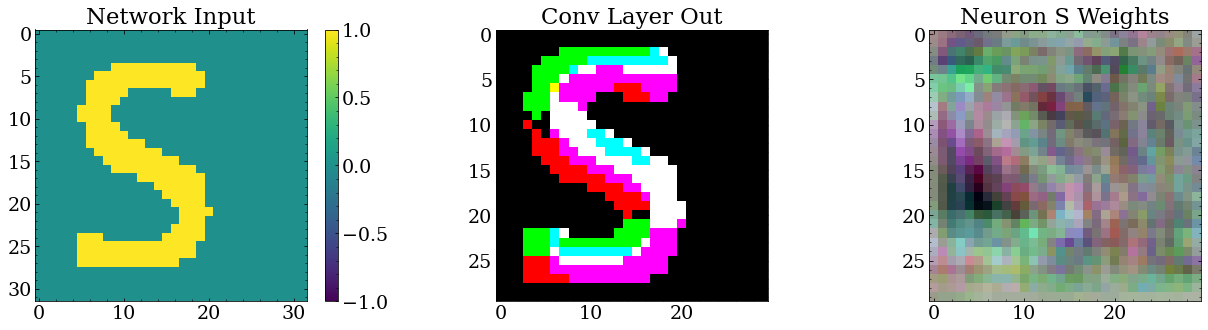

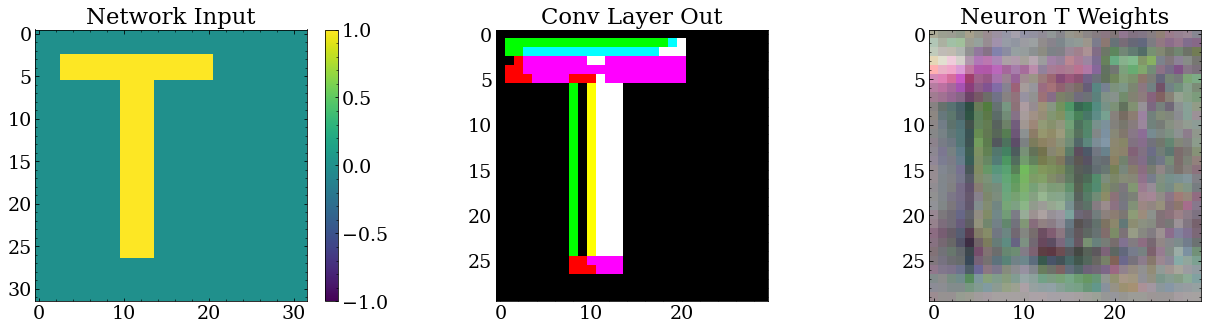

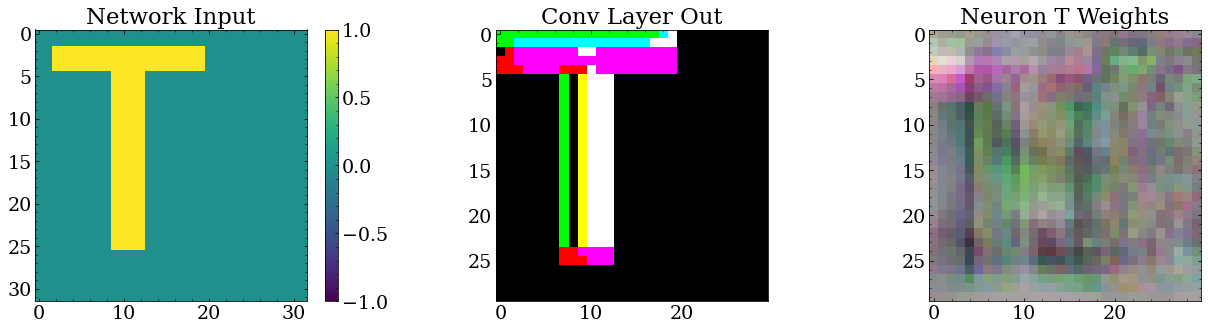

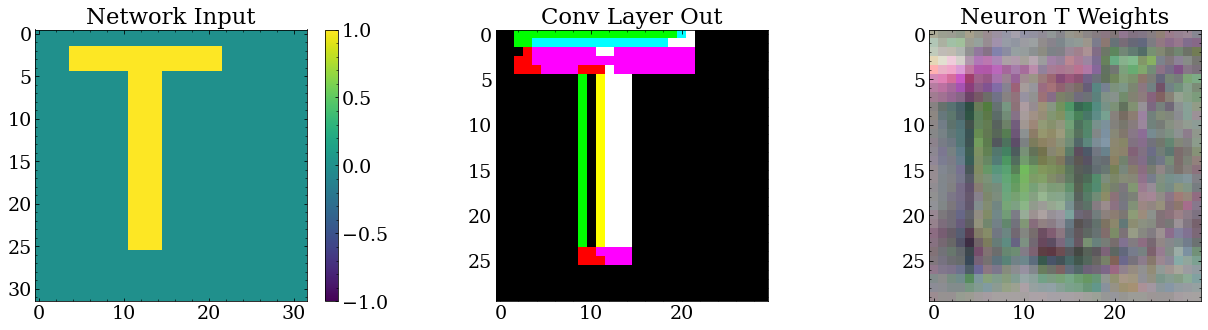

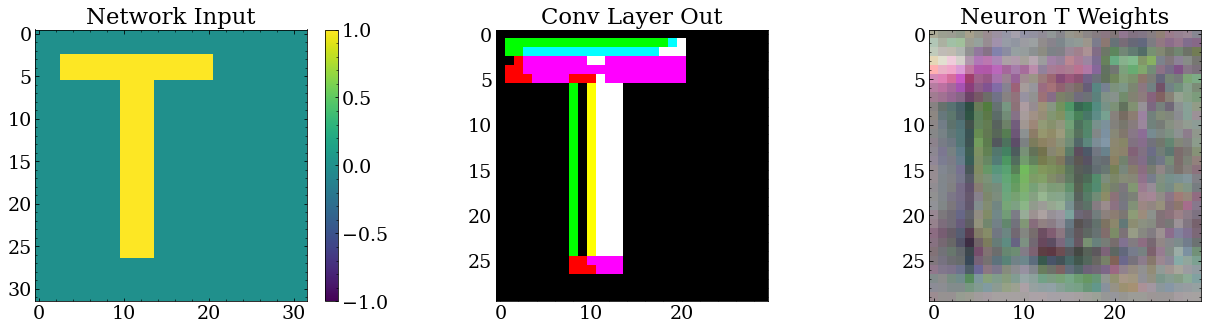

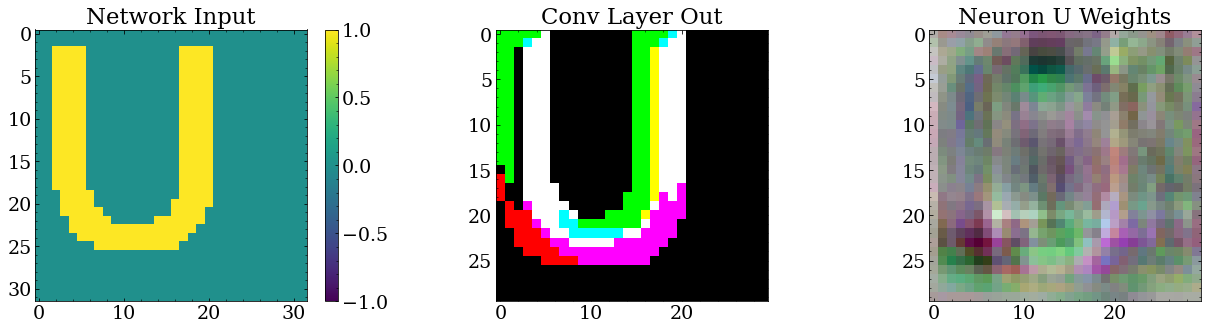

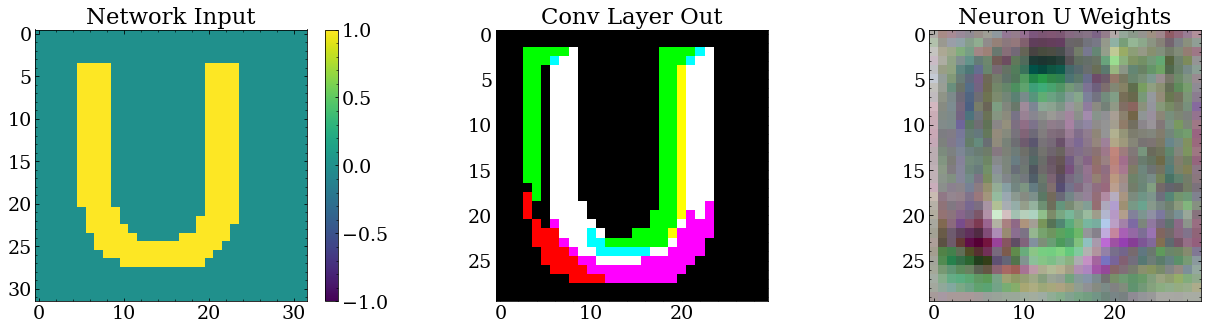

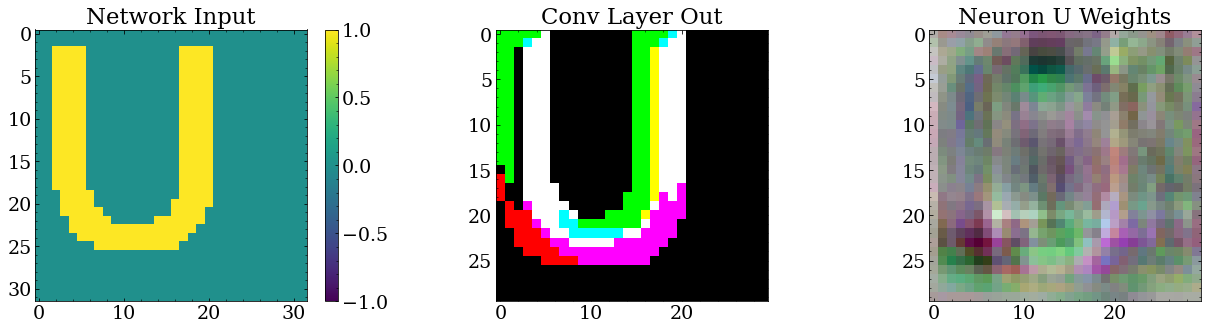

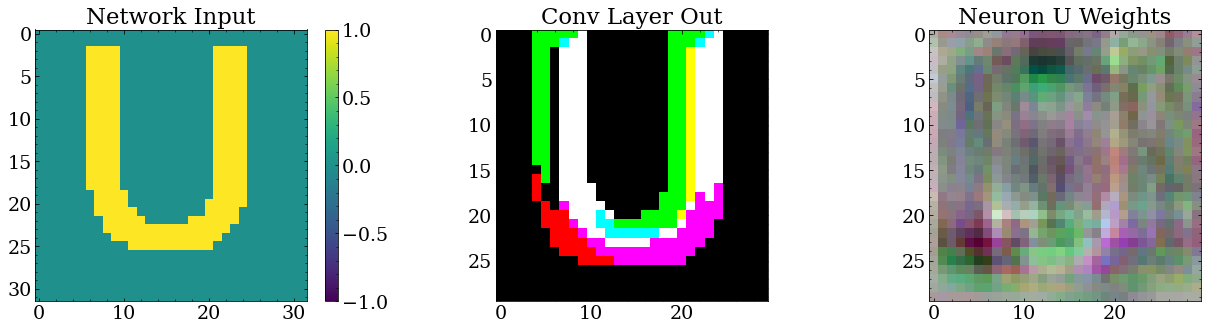

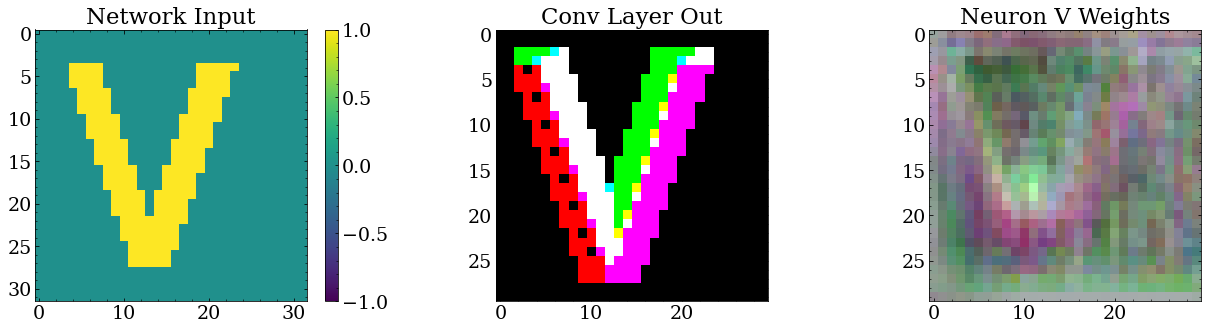

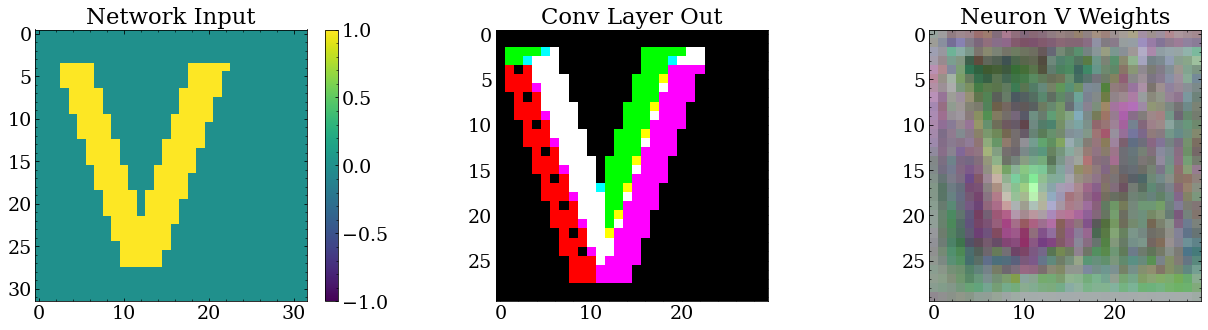

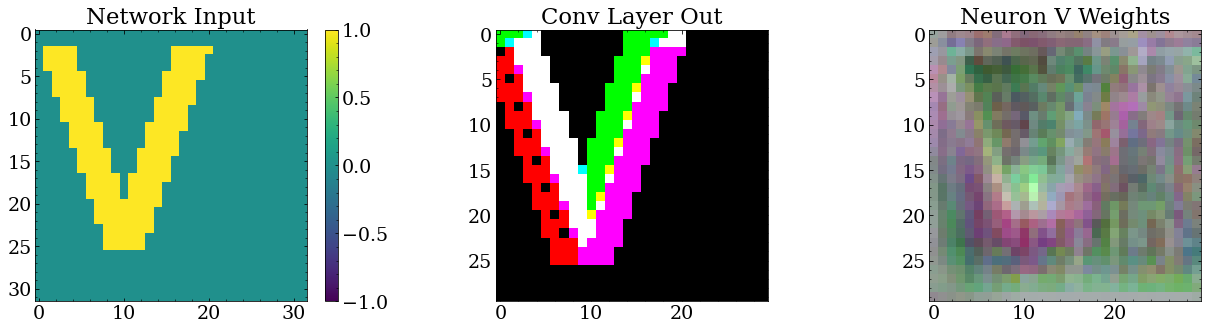

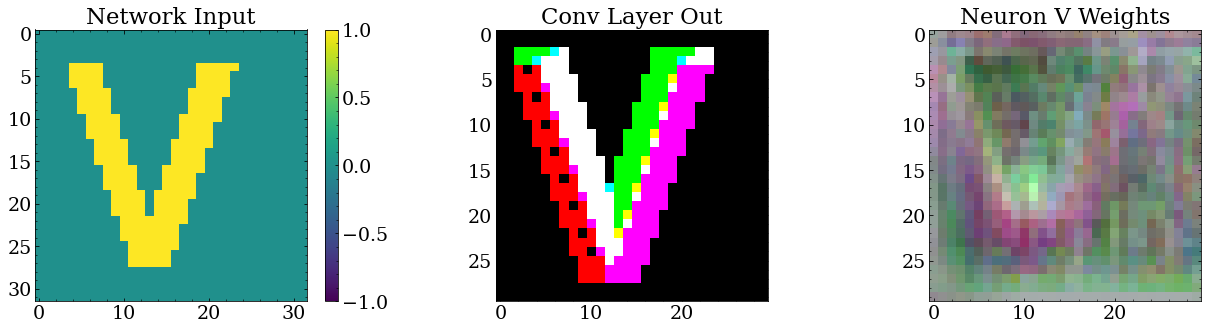

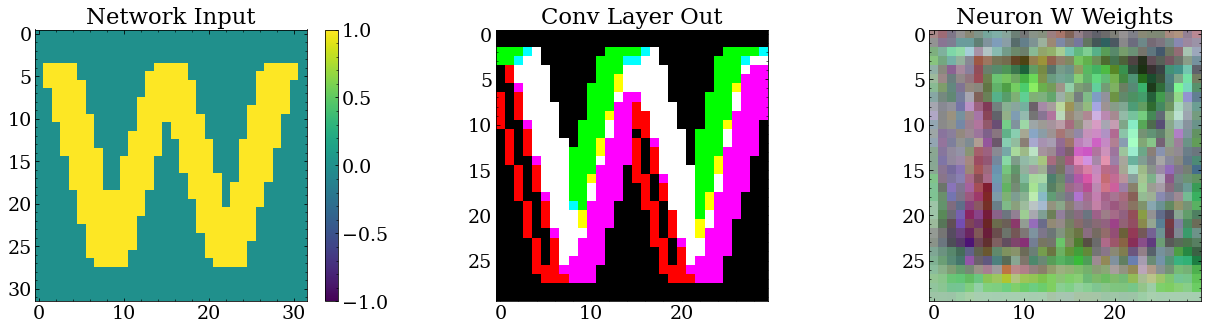

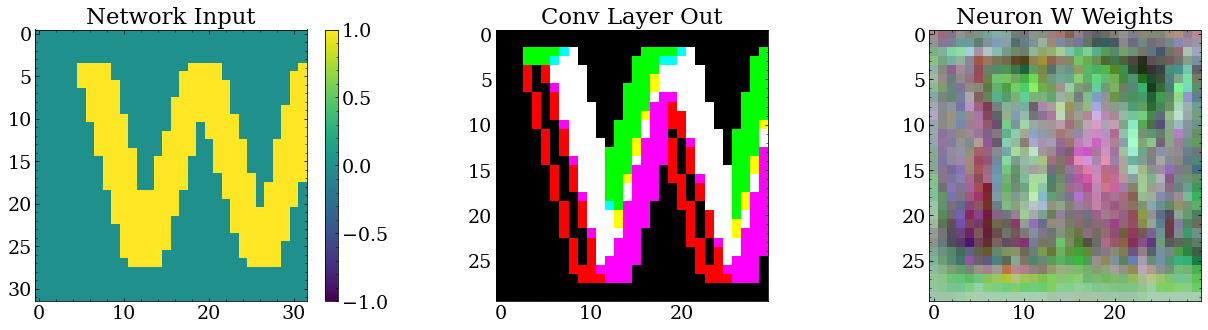

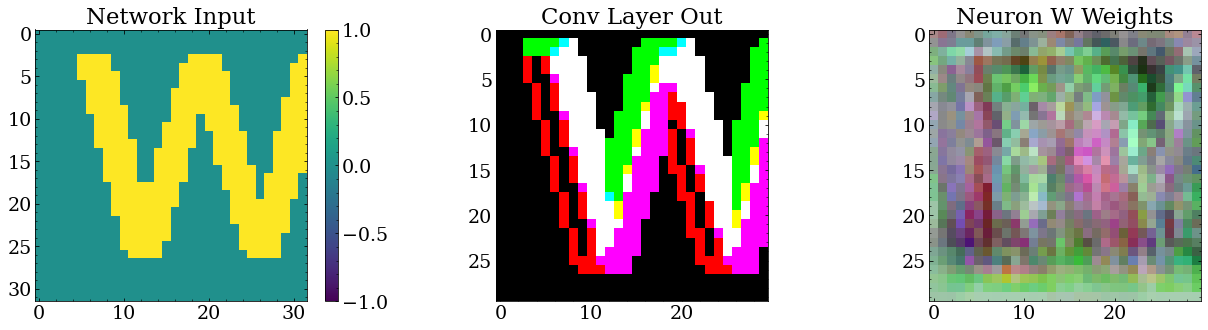

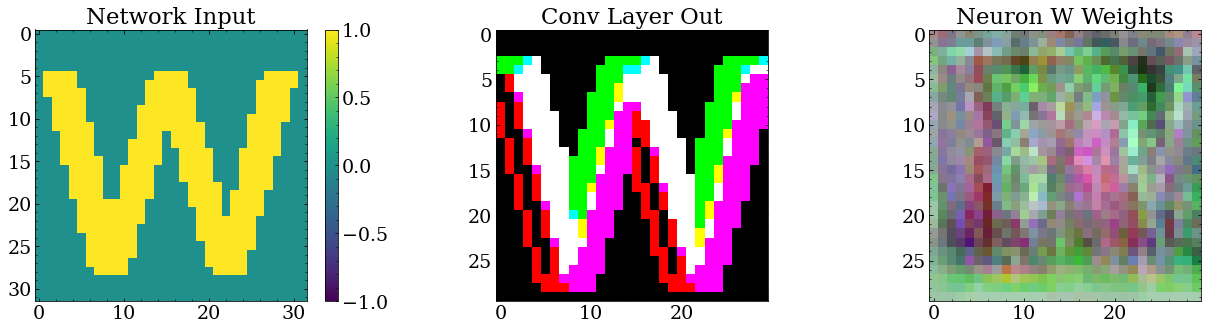

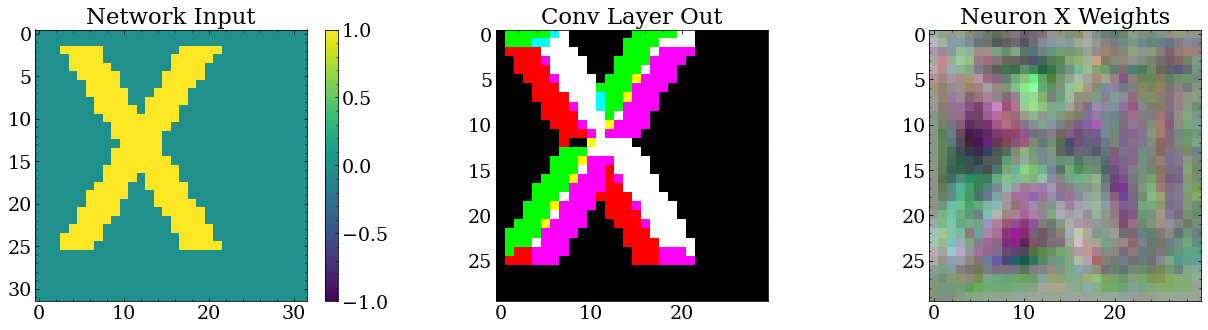

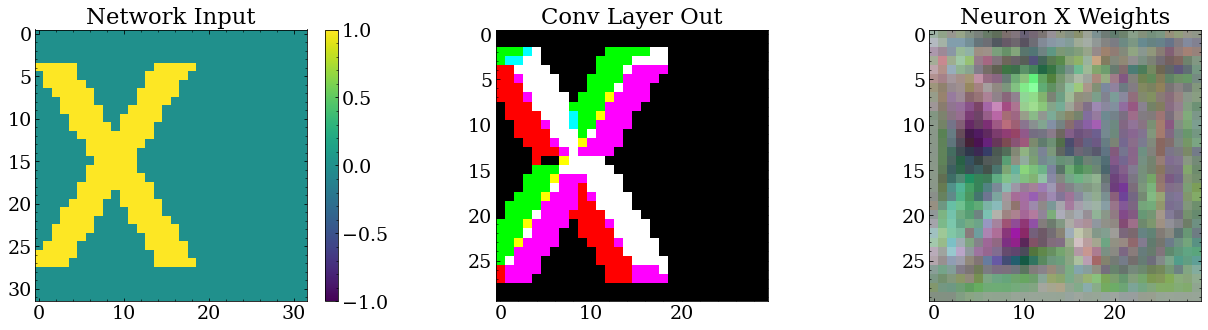

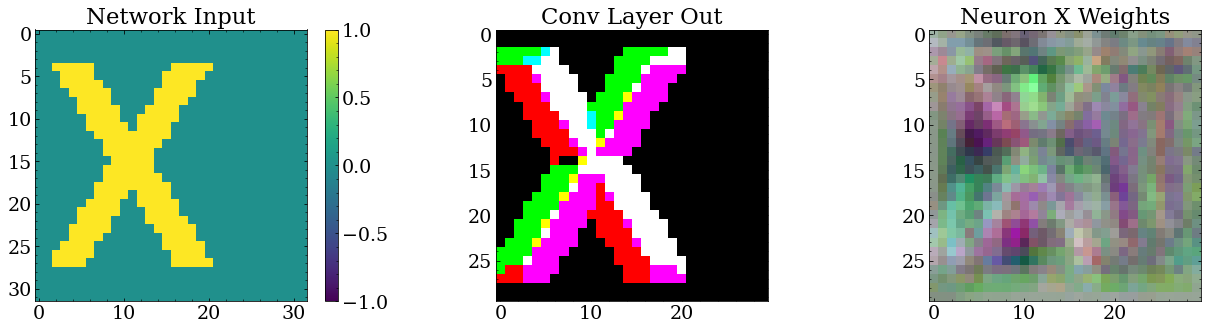

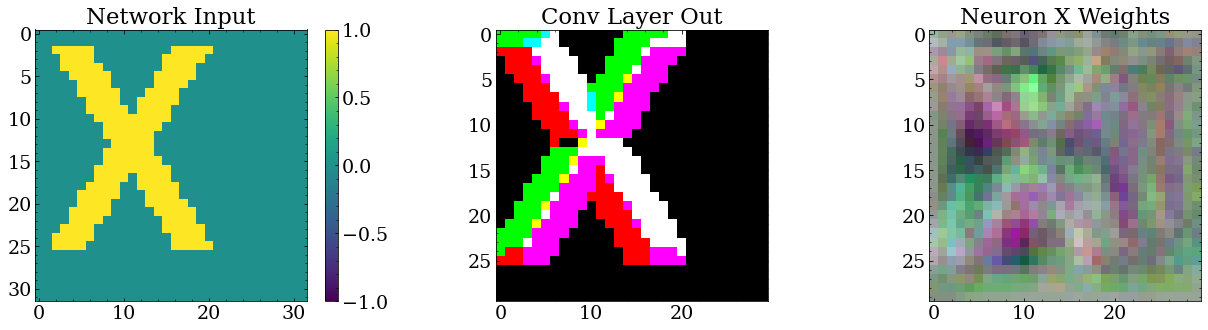

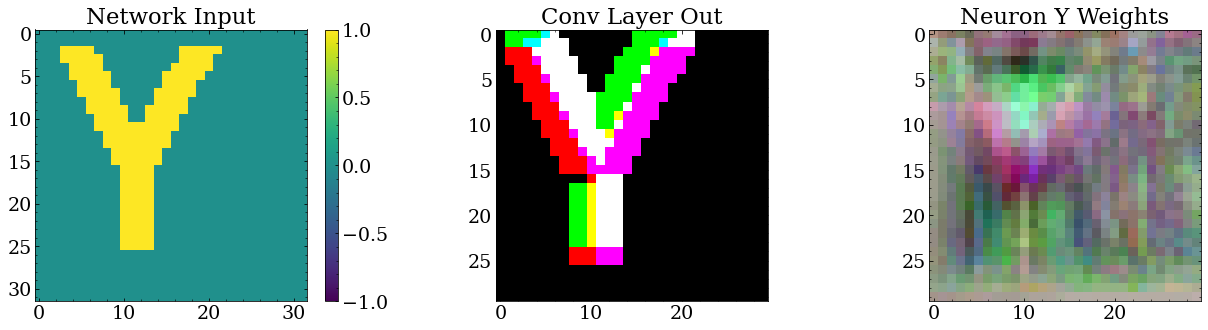

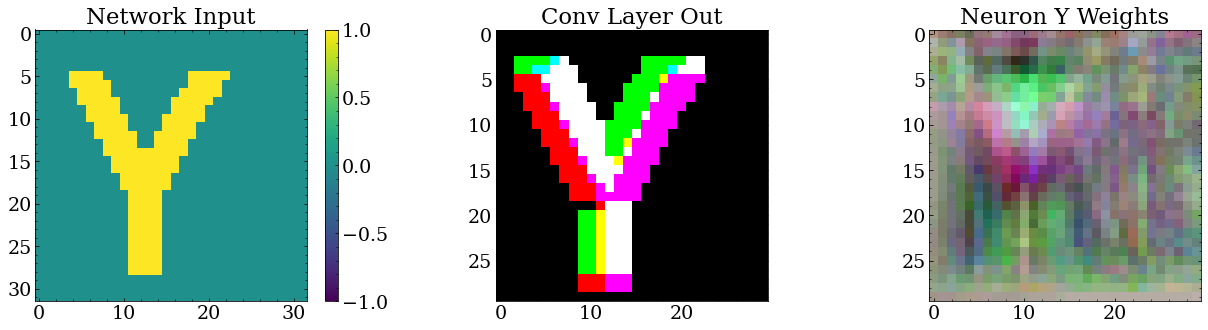

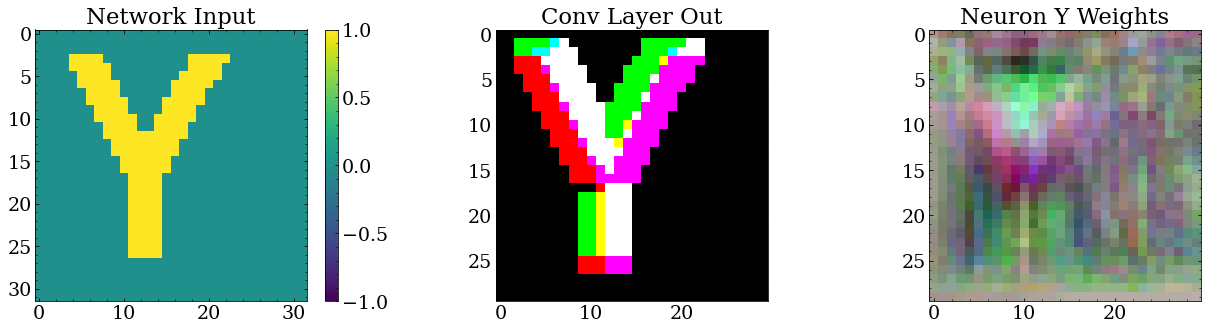

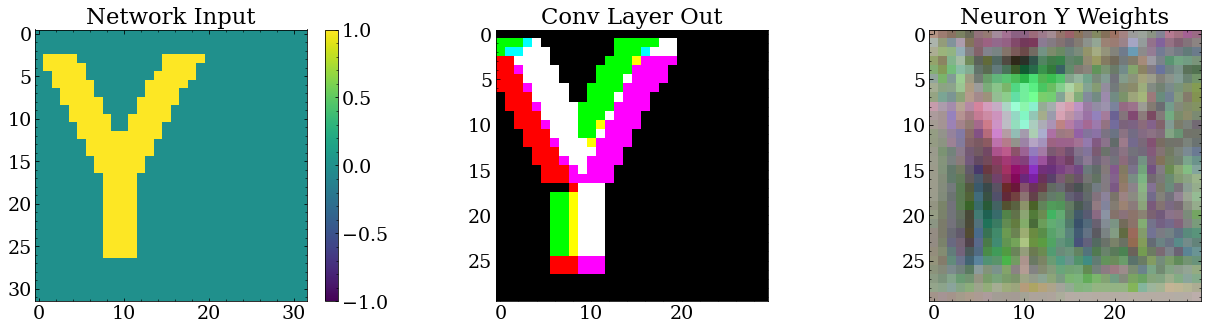

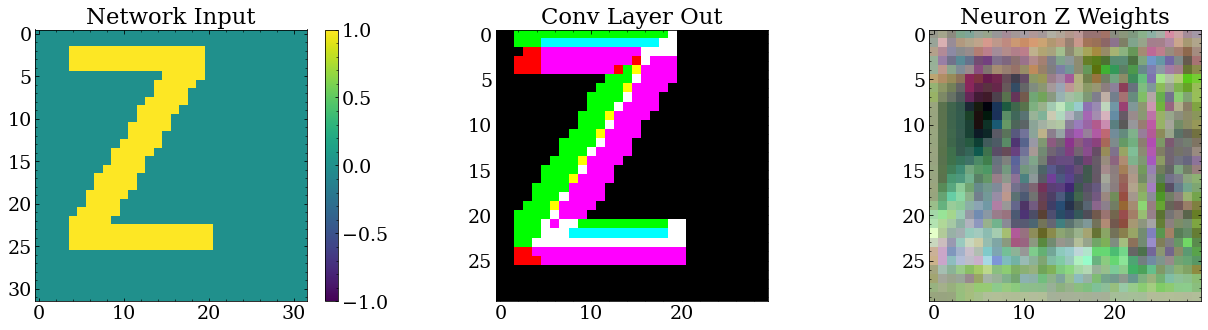

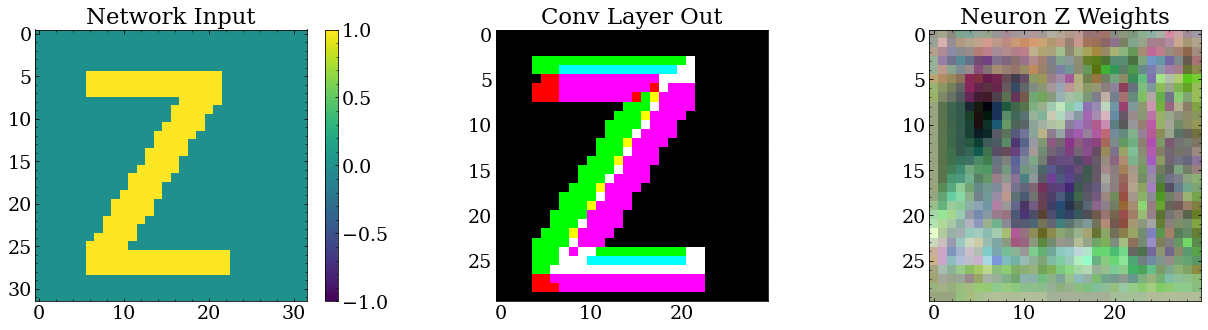

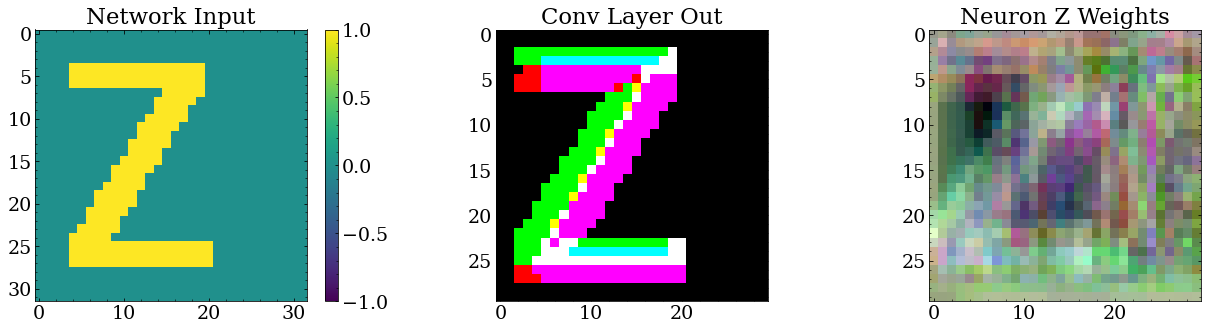

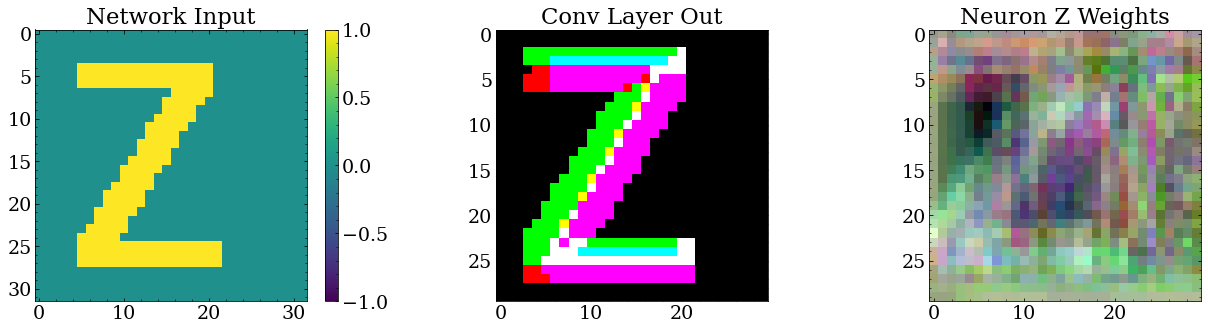

In [16]:
#to plot a simple one hidden layer network

from matplotlib.colors import Normalize

true_norm = Normalize(-1,1)
hidden_shapes = [(5,10)]

for i,iout in enumerate(s.outputs):
    letter = ocr_data.letters[i]
    for trial in range(4):
        test_in = ocr_data.gen_data(letter)[1]


        pltmagic = 100 + 20 + hidden_layers*10 + conv_layers*10
        plt.figure(figsize=[22,5])


        guess_out,state = s.guess(test_in.flatten(),return_state=True)
        inputs = insts[0].get_state(state)

        plt.subplot(pltmagic+1)
        plt.title('Network Input')
        plt.imshow(inputs,norm=true_norm)
        plt.colorbar()

        last_shape = test_in.shape
        for j in range(conv_layers):
            img_hidden = insts[1+j].get_state(state)

            plt.subplot(pltmagic+2+j)
            plt.title('Conv Layer Out')
            plt.imshow((img_hidden+1)/2)
            #plt.colorbar()


        for j in range(hidden_layers):
            img_hidden = insts[1+conv_layers+j].get_state(state)

            plt.subplot(pltmagic+2+conv_layers+j)
            plt.title('Hidden Layer Out')
            plt.imshow(img_hidden)
            plt.colorbar()

        plt.subplot(pltmagic+conv_layers+2+hidden_layers)
        plt.title('Neuron ''%s'' Weights'%letter)
        img_weights = insts[-1].neurons[i].weights.reshape(insts[-2].outputs.shape)
        norm = np.max(np.abs(img_weights))
        #weight_norm = Normalize(-norm,norm)
        #plt.imshow(img_weights,norm=weight_norm)
        plt.imshow((img_weights/norm+1)/2)
        plt.show()
        plt.close()